In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Load the data

data_path= "explicit_confidence_task_logs/llama-3.1-8b-instruct_PopMC_0_difficulty_filtered_500_2025-11-21-13-39-04_explicit_confidence_task_all.json"
# data_path= "explicit_confidence_task_logs/llama-3.3-70b-instruct_PopMC_0_difficulty_filtered_500_2025-11-21-18-07-27_explicit_confidence_task_all.json"
with open(data_path, 'r') as f:
    data = json.load(f)

# Extract model name and dataset from filename
filename = Path(data_path).stem  # Get filename without extension
# Pattern: model_dataset_rest...
# Split by underscore and extract model (first part) and dataset (second part, but may have more parts)
parts = filename.split('_')
model_name = parts[0]  # e.g., "llama-3.1-8b-instruct"

# Dataset is trickier - it's usually the second part, but might have additional parts
# Look for the first part that looks like a dataset name (before numbers)
dataset_name = parts[1] if len(parts) > 1 else "Unknown"
# Handle cases like "PopMC_0_difficulty_filtered" - take the full dataset name
# Try to find the dataset by looking at common patterns
if 'PopMC' in filename and 'difficulty' in filename and 'filtered' in filename:
    dataset_name = 'PopMC 0 Difficulty Filtered'
elif 'PopMC' in filename:
    dataset_name = 'PopMC'
elif 'SimpleMC' in filename:
    dataset_name = 'SimpleMC'
elif 'GPQA' in filename:
    dataset_name = 'GPQA'
elif 'TriviaMC' in filename:
    dataset_name = 'TriviaMC'
else:
    dataset_name = parts[1]

print(f"Model: {model_name}")
print(f"Dataset: {dataset_name}")
print(f"Subject ID: {data['subject_id']}")
print(f"Overall Accuracy: {data['accuracy']:.2%}")
print(f"Number of questions: {len(data['results'])}")


Model: llama-3.1-8b-instruct
Dataset: PopMC 0 Difficulty Filtered
Subject ID: llama-3.1-8b-instruct_PopMC_0_difficulty_filtered_500
Overall Accuracy: 56.40%
Number of questions: 500


In [2]:
# ============================================================================
# CONFIGURATION: How to handle invalid confidence keys (like "I", "J", etc.)
# ============================================================================
# Option 1: "filter" - Filter out invalid keys (current default, recommended)
#           This is correct because invalid keys appear due to top-k logprobs
#           including any token, not just valid options. The model's chosen
#           answer (A-H) is still correctly identified.
# Option 2: "map_to_h" - Map "I" to "H" if probability > threshold
#           Treats "I" as maximum confidence (>95%)
# Option 3: "extend_scale" - Add "I" as a new option for >95% confidence
#           Extends the scale: A-H as before, I = >95% (midpoint 0.975)
HANDLE_INVALID_KEYS = "filter"  # Options: "filter", "map_to_h", "extend_scale"
MAP_I_TO_H_THRESHOLD = 0.01  # Only map "I" to "H" if probability > this threshold

# ============================================================================

# Extract data for each question
questions_data = []
invalid_confidence_answers = []
missing_correct_answer_probs = []
questions_with_invalid_confidence_keys = []  # Track questions with invalid keys in confidence_probs

# Confidence range midpoints from run_parameters
confidence_midpoints = data['run_parameters']['nested_range_midpoints'].copy()

# If extending scale, add "I" option
if HANDLE_INVALID_KEYS == "extend_scale":
    confidence_midpoints["I"] = 0.975  # >95% confidence
    print(f"Extended confidence scale: Added 'I' option for >95% confidence (midpoint: 0.975)")

# Check if this is nested="All" format (has self_confidence and other_confidence) 
# or explicit_confidence_task format (has confidence)
has_self_confidence = any('self_confidence_answer' in q_data for q_data in data['results'].values())
has_other_confidence = any('other_confidence_answer' in q_data for q_data in data['results'].values())
has_confidence = any('confidence_answer' in q_data for q_data in data['results'].values())

for q_id, q_data in data['results'].items():
    probs = q_data['probs']
    subject_answer = q_data['subject_answer']
    correct_answer = q_data['question']['correct_answer']
    is_correct = q_data['is_correct']
    
    # Handle different data formats
    if has_self_confidence and has_other_confidence:
        # nested="All" format
        self_confidence_probs = q_data.get('self_confidence_probs', {})
        self_confidence_answer = q_data.get('self_confidence_answer')
        other_confidence_probs = q_data.get('other_confidence_probs', {})
        other_confidence_answer = q_data.get('other_confidence_answer')
        confidence_probs = self_confidence_probs  # For backward compatibility
        confidence_answer = self_confidence_answer
    elif has_confidence:
        # explicit_confidence_task format (single confidence question)
        confidence_probs = q_data.get('confidence_probs', {})
        confidence_answer = q_data.get('confidence_answer')
        self_confidence_probs = confidence_probs  # Map to self_confidence for consistency
        self_confidence_answer = confidence_answer
        other_confidence_probs = {}
        other_confidence_answer = None
    else:
        # No confidence data available
        continue
    
    # Validate self_confidence_answer is a valid bucket (A-H)
    if self_confidence_answer and self_confidence_answer not in confidence_midpoints:
        invalid_confidence_answers.append({
            'question_id': q_id,
            'confidence_answer': self_confidence_answer,
            'valid_options': list(confidence_midpoints.keys())
        })
        continue  # Skip this question if confidence answer is invalid
    
    # Validate other_confidence_answer if present
    if other_confidence_answer and other_confidence_answer not in confidence_midpoints:
        invalid_confidence_answers.append({
            'question_id': q_id,
            'confidence_answer': other_confidence_answer,
            'valid_options': list(confidence_midpoints.keys())
        })
        continue
    
    # Validate that subject_answer and correct_answer are in probs
    if subject_answer not in probs:
        missing_correct_answer_probs.append({
            'question_id': q_id,
            'subject_answer': subject_answer,
            'available_probs': list(probs.keys())
        })
        continue  # Skip this question if subject_answer is not in probs
    
    if correct_answer not in probs:
        missing_correct_answer_probs.append({
            'question_id': q_id,
            'correct_answer': correct_answer,
            'available_probs': list(probs.keys())
        })
        continue  # Skip this question if correct_answer is not in probs
    
    # Apply softmax normalization to answer probabilities
    def softmax_normalize(prob_dict):
        """Normalize probabilities to sum to 1 (simple normalization, not true softmax)
        Since these are already probabilities from exp(logprob), we just need to normalize by sum"""
        if not prob_dict:
            return {}
        total = sum(prob_dict.values())
        if total == 0:
            return prob_dict  # Return original if sum is 0 (shouldn't happen)
        # Normalize by dividing by sum
        normalized_probs = {key: prob / total for key, prob in prob_dict.items()}
        return normalized_probs
    
    # Filter out invalid keys from confidence_probs (only keep A-H)
    # Track invalid keys found with their actual values
    # Note: Invalid keys like "I" appear because top-k logprobs can include any token,
    # not just valid options. This is expected behavior, not a bug.
    invalid_self_key_values = {
        level: prob 
        for level, prob in (self_confidence_probs.items() if self_confidence_probs else {}.items())
        if level not in confidence_midpoints
    }
    invalid_other_key_values = {
        level: prob 
        for level, prob in (other_confidence_probs.items() if other_confidence_probs else {}.items())
        if level not in confidence_midpoints
    }
    
    invalid_self_keys = list(invalid_self_key_values.keys())
    invalid_other_keys = list(invalid_other_key_values.keys())
    
    # Handle invalid keys based on configuration
    if HANDLE_INVALID_KEYS == "map_to_h":
        # Map "I" to "H" if it appears with significant probability
        if "I" in invalid_self_key_values and invalid_self_key_values["I"] > MAP_I_TO_H_THRESHOLD:
            if "H" in self_confidence_probs:
                self_confidence_probs["H"] += invalid_self_key_values["I"]
            else:
                self_confidence_probs["H"] = invalid_self_key_values["I"]
            invalid_self_key_values.pop("I", None)
            invalid_self_keys = [k for k in invalid_self_keys if k != "I"]
        
        if "I" in invalid_other_key_values and invalid_other_key_values["I"] > MAP_I_TO_H_THRESHOLD:
            if "H" in other_confidence_probs:
                other_confidence_probs["H"] += invalid_other_key_values["I"]
            else:
                other_confidence_probs["H"] = invalid_other_key_values["I"]
            invalid_other_key_values.pop("I", None)
            invalid_other_keys = [k for k in invalid_other_keys if k != "I"]
    
    if invalid_self_keys or invalid_other_keys:
        questions_with_invalid_confidence_keys.append({
            'question_id': q_id,
            'invalid_self_keys': invalid_self_keys,
            'invalid_self_key_values': invalid_self_key_values,
            'invalid_other_keys': invalid_other_keys,
            'invalid_other_key_values': invalid_other_key_values,
            'self_confidence_answer': self_confidence_answer,
            'other_confidence_answer': other_confidence_answer
        })
    
    self_confidence_probs_filtered = {
        level: prob 
        for level, prob in self_confidence_probs.items() 
        if level in confidence_midpoints
    } if self_confidence_probs else {}
    
    other_confidence_probs_filtered = {
        level: prob 
        for level, prob in other_confidence_probs.items() 
        if level in confidence_midpoints
    } if other_confidence_probs else {}
    
    # Normalize answer probabilities
    probs_normalized = softmax_normalize(probs)
    
    # Normalize self-confidence probabilities (using filtered version)
    self_confidence_probs_normalized = softmax_normalize(self_confidence_probs_filtered) if self_confidence_probs_filtered else {}
    
    # Normalize other-confidence probabilities (using filtered version)
    other_confidence_probs_normalized = softmax_normalize(other_confidence_probs_filtered) if other_confidence_probs_filtered else {}
    
    # Extract key metrics from probs (unnormalized - original)
    max_prob = max(probs.values())  # Probability of the most likely answer
    chosen_prob = probs[subject_answer]  # Probability of the chosen answer
    correct_prob = probs[correct_answer]  # Probability of the correct answer
    
    # Extract key metrics from normalized probs
    max_prob_norm = max(probs_normalized.values()) if probs_normalized else 0
    chosen_prob_norm = probs_normalized.get(subject_answer, 0) if probs_normalized else 0
    correct_prob_norm = probs_normalized.get(correct_answer, 0) if probs_normalized else 0
    
    # Extract key metrics from self_confidence_probs (unnormalized, using filtered version)
    max_self_confidence_prob = max(self_confidence_probs_filtered.values()) if self_confidence_probs_filtered else 0
    chosen_self_confidence_prob = self_confidence_probs_filtered.get(self_confidence_answer, 0) if self_confidence_answer else 0
    
    # Calculate expected self-confidence (weighted average) - unnormalized
    expected_self_confidence = sum(
        confidence_midpoints[level] * prob 
        for level, prob in self_confidence_probs_filtered.items()
    ) if self_confidence_probs_filtered else None
    
    # Extract key metrics from normalized self_confidence_probs
    max_self_confidence_prob_norm = max(self_confidence_probs_normalized.values()) if self_confidence_probs_normalized else 0
    chosen_self_confidence_prob_norm = self_confidence_probs_normalized.get(self_confidence_answer, 0) if self_confidence_answer and self_confidence_probs_normalized else 0
    
    # Calculate expected self-confidence (weighted average) - normalized
    expected_self_confidence_norm = sum(
        confidence_midpoints[level] * prob 
        for level, prob in self_confidence_probs_normalized.items()
    ) if self_confidence_probs_normalized else None
    
    # Extract key metrics from other_confidence_probs (if available) - unnormalized, using filtered version
    max_other_confidence_prob = max(other_confidence_probs_filtered.values()) if other_confidence_probs_filtered else None
    chosen_other_confidence_prob = other_confidence_probs_filtered.get(other_confidence_answer, 0) if other_confidence_answer else None
    
    # Calculate expected other-confidence (weighted average) - unnormalized
    expected_other_confidence = sum(
        confidence_midpoints[level] * prob 
        for level, prob in other_confidence_probs_filtered.items()
    ) if other_confidence_probs_filtered else None
    
    # Extract key metrics from normalized other_confidence_probs
    max_other_confidence_prob_norm = max(other_confidence_probs_normalized.values()) if other_confidence_probs_normalized else None
    chosen_other_confidence_prob_norm = other_confidence_probs_normalized.get(other_confidence_answer, 0) if other_confidence_answer and other_confidence_probs_normalized else None
    
    # Calculate expected other-confidence (weighted average) - normalized
    expected_other_confidence_norm = sum(
        confidence_midpoints[level] * prob 
        for level, prob in other_confidence_probs_normalized.items()
    ) if other_confidence_probs_normalized else None
    
    # Calculate entropy of probs (uncertainty in answer) - unnormalized
    answer_entropy = -sum(p * np.log(p + 1e-10) for p in probs.values())
    
    # Calculate entropy of normalized probs
    answer_entropy_norm = -sum(p * np.log(p + 1e-10) for p in probs_normalized.values()) if probs_normalized else None
    
    # Calculate entropy of self_confidence_probs (uncertainty in self-confidence) - unnormalized, using filtered version
    self_confidence_entropy = -sum(p * np.log(p + 1e-10) for p in self_confidence_probs_filtered.values()) if self_confidence_probs_filtered else None
    
    # Calculate entropy of normalized self_confidence_probs
    self_confidence_entropy_norm = -sum(p * np.log(p + 1e-10) for p in self_confidence_probs_normalized.values()) if self_confidence_probs_normalized else None
    
    # Calculate entropy of other_confidence_probs (uncertainty in other-confidence) - unnormalized, using filtered version
    other_confidence_entropy = -sum(p * np.log(p + 1e-10) for p in other_confidence_probs_filtered.values()) if other_confidence_probs_filtered else None
    
    # Calculate entropy of normalized other_confidence_probs
    other_confidence_entropy_norm = -sum(p * np.log(p + 1e-10) for p in other_confidence_probs_normalized.values()) if other_confidence_probs_normalized else None
    
    # For backward compatibility, use self_confidence as the main confidence measure
    confidence_entropy = self_confidence_entropy
    expected_confidence = expected_self_confidence
    confidence_midpoint = confidence_midpoints[self_confidence_answer] if self_confidence_answer else None
    
    # Other confidence midpoint
    other_confidence_midpoint = confidence_midpoints[other_confidence_answer] if other_confidence_answer else None
    
    questions_data.append({
        'question_id': q_id,
        'is_correct': is_correct,
        # Unnormalized probabilities
        'max_prob': max_prob,
        'chosen_prob': chosen_prob,
        'correct_prob': correct_prob,
        'max_self_confidence_prob': max_self_confidence_prob,
        'chosen_self_confidence_prob': chosen_self_confidence_prob,
        'expected_self_confidence': expected_self_confidence,
        'self_confidence_answer': self_confidence_answer,
        'self_confidence_midpoint': confidence_midpoint,
        'self_confidence_entropy': self_confidence_entropy,
        'max_other_confidence_prob': max_other_confidence_prob,
        'chosen_other_confidence_prob': chosen_other_confidence_prob,
        'expected_other_confidence': expected_other_confidence,
        'other_confidence_answer': other_confidence_answer,
        'other_confidence_midpoint': other_confidence_midpoint,
        'other_confidence_entropy': other_confidence_entropy,
        # Normalized probabilities (softmax)
        'max_prob_norm': max_prob_norm,
        'chosen_prob_norm': chosen_prob_norm,
        'correct_prob_norm': correct_prob_norm,
        'max_self_confidence_prob_norm': max_self_confidence_prob_norm,
        'chosen_self_confidence_prob_norm': chosen_self_confidence_prob_norm,
        'expected_self_confidence_norm': expected_self_confidence_norm,
        'self_confidence_entropy_norm': self_confidence_entropy_norm,
        'max_other_confidence_prob_norm': max_other_confidence_prob_norm,
        'chosen_other_confidence_prob_norm': chosen_other_confidence_prob_norm,
        'expected_other_confidence_norm': expected_other_confidence_norm,
        'other_confidence_entropy_norm': other_confidence_entropy_norm,
        'answer_entropy_norm': answer_entropy_norm,
        # Backward compatibility fields
        'max_confidence_prob': max_self_confidence_prob,
        'chosen_confidence_prob': chosen_self_confidence_prob,
        'expected_confidence': expected_confidence,
        'confidence_answer': self_confidence_answer,
        'confidence_midpoint': confidence_midpoint,
        'confidence_entropy': confidence_entropy,
        'answer_entropy': answer_entropy,
        'subject_answer': subject_answer,
        'correct_answer': correct_answer
    })

# Report any invalid confidence answers
if invalid_confidence_answers:
    print(f"\n⚠️  WARNING: Found {len(invalid_confidence_answers)} questions with invalid confidence answers:")
    for item in invalid_confidence_answers:
        print(f"  Question {item['question_id']}: confidence_answer='{item['confidence_answer']}' (not in {item['valid_options']})")
    print(f"\nThese questions were excluded from analysis.")
else:
    print("\n✅ All confidence answers are valid.")

# Report any missing answer probabilities
if missing_correct_answer_probs:
    print(f"\n⚠️  WARNING: Found {len(missing_correct_answer_probs)} questions with missing answer probabilities:")
    for item in missing_correct_answer_probs:
        if 'subject_answer' in item:
            print(f"  Question {item['question_id']}: subject_answer='{item['subject_answer']}' not in probs (available: {item['available_probs']})")
        elif 'correct_answer' in item:
            print(f"  Question {item['question_id']}: correct_answer='{item['correct_answer']}' not in probs (available: {item['available_probs']})")
    print(f"\nThese questions were excluded from analysis.")
else:
    print("\n✅ All answer probabilities are valid.")

# Report questions with invalid keys in confidence_probs (filtered out but question still included)
if questions_with_invalid_confidence_keys:
    print(f"\n⚠️  INFO: Found {len(questions_with_invalid_confidence_keys)} questions with invalid keys in confidence_probs:")
    # Count unique invalid keys
    all_invalid_self_keys = []
    all_invalid_other_keys = []
    for item in questions_with_invalid_confidence_keys:
        all_invalid_self_keys.extend(item['invalid_self_keys'])
        all_invalid_other_keys.extend(item['invalid_other_keys'])
    
    from collections import Counter
    self_key_counts = Counter(all_invalid_self_keys)
    other_key_counts = Counter(all_invalid_other_keys)
    
    if self_key_counts:
        print(f"  Invalid keys in self_confidence_probs: {dict(self_key_counts)}")
    if other_key_counts:
        print(f"  Invalid keys in other_confidence_probs: {dict(other_key_counts)}")
    
    print(f"  These invalid keys were filtered out from calculations, but questions were still included in analysis.")
    print(f"  NOTE: Invalid keys (like 'I', 'J', etc.) appear because the API returns top-k logprobs,")
    print(f"        which can include any token, not just valid options. This is expected behavior.")
    print(f"        The model's chosen answer (A-H) is still correctly identified.")
    print(f"  First 5 examples:")
    for item in questions_with_invalid_confidence_keys[:5]:
        print(f"    Question {item['question_id']}:")
        if item['invalid_self_keys']:
            invalid_pairs = item.get('invalid_self_key_values', {})
            print(f"      Invalid keys in self_confidence_probs dictionary: {item['invalid_self_keys']}")
            if invalid_pairs:
                print(f"        Key-value pairs: {invalid_pairs}")
            print(f"        (self_confidence_answer: {item['self_confidence_answer']})")
        if item['invalid_other_keys']:
            invalid_pairs = item.get('invalid_other_key_values', {})
            print(f"      Invalid keys in other_confidence_probs dictionary: {item['invalid_other_keys']}")
            if invalid_pairs:
                print(f"        Key-value pairs: {invalid_pairs}")
            print(f"        (other_confidence_answer: {item['other_confidence_answer']})")
else:
    print("\n✅ All confidence_probs dictionaries contain only valid keys (A-H).")

# Summary of filtering
total_questions = len(data['results'])
excluded_questions = len(invalid_confidence_answers) + len(missing_correct_answer_probs)
included_questions = len(questions_data)
questions_with_filtered_keys = len(questions_with_invalid_confidence_keys)

print(f"\n{'='*60}")
print(f"SUMMARY:")
print(f"{'='*60}")
print(f"Total questions in dataset: {total_questions}")
print(f"Questions excluded (invalid answers/missing probs): {excluded_questions}")
print(f"Questions included in analysis: {included_questions}")
print(f"Questions with invalid keys filtered from confidence_probs: {questions_with_filtered_keys}")
if questions_with_filtered_keys > 0:
    print(f"  (Note: These questions were still included, but invalid keys were removed)")
print(f"{'='*60}\n")

df = pd.DataFrame(questions_data)
print("\nExtracted Data:")
print(df[['question_id', 'is_correct', 'chosen_prob', 'correct_prob', 
          'expected_confidence', 'confidence_midpoint', 'answer_entropy', 'confidence_entropy']].to_string())



✅ All confidence answers are valid.

✅ All answer probabilities are valid.

✅ All confidence_probs dictionaries contain only valid keys (A-H).

SUMMARY:
Total questions in dataset: 500
Questions excluded (invalid answers/missing probs): 0
Questions included in analysis: 500
Questions with invalid keys filtered from confidence_probs: 0


Extracted Data:
            question_id  is_correct  chosen_prob  correct_prob  expected_confidence  confidence_midpoint  answer_entropy  confidence_entropy
0     popmc_test_632612        True     0.994310  9.943104e-01             0.716729                0.850        0.036151            1.434696
1     popmc_test_780748       False     0.465087  7.244658e-02             0.206687                0.025        1.207509            1.571475
2    popmc_test_2647046        True     0.851071  8.510711e-01             0.427899                0.025        0.539050            2.057408
3    popmc_test_1181931        True     0.545545  5.455451e-01             0.587

In [3]:
# Statistical summary
print("\n=== STATISTICAL SUMMARY ===")
print(f"\nAccuracy by chosen probability:")
print(df.groupby('is_correct')['chosen_prob'].describe())

print(f"\nAccuracy by expected self-confidence:")
print(df.groupby('is_correct')['expected_self_confidence'].describe())

if df['expected_other_confidence'].notna().any():
    print(f"\nAccuracy by expected other-confidence:")
    print(df.groupby('is_correct')['expected_other_confidence'].describe())

print(f"\nCorrelation between chosen_prob and expected_self_confidence:")
corr = df['chosen_prob'].corr(df['expected_self_confidence'])
print(f"Pearson correlation: {corr:.3f}")

if df['expected_other_confidence'].notna().any():
    print(f"\nCorrelation between chosen_prob and expected_other_confidence:")
    corr_other = df['chosen_prob'].corr(df['expected_other_confidence'])
    print(f"Pearson correlation: {corr_other:.3f}")

print(f"\nCorrelation between correct_prob and expected_self_confidence:")
corr_correct = df['correct_prob'].corr(df['expected_self_confidence'])
print(f"Pearson correlation: {corr_correct:.3f}")

if df['expected_other_confidence'].notna().any():
    print(f"\nCorrelation between correct_prob and expected_other_confidence:")
    corr_correct_other = df['correct_prob'].corr(df['expected_other_confidence'])
    print(f"Pearson correlation: {corr_correct_other:.3f}")

print(f"\nCorrelation between chosen_prob and self_confidence_midpoint:")
corr_midpoint = df['chosen_prob'].corr(df['self_confidence_midpoint'])
print(f"Pearson correlation: {corr_midpoint:.3f}")

if df['other_confidence_midpoint'].notna().any():
    print(f"\nCorrelation between chosen_prob and other_confidence_midpoint:")
    corr_midpoint_other = df['chosen_prob'].corr(df['other_confidence_midpoint'])
    print(f"Pearson correlation: {corr_midpoint_other:.3f}")

if df['expected_other_confidence'].notna().any():
    print(f"\nCorrelation between expected_self_confidence and expected_other_confidence:")
    corr_self_other = df['expected_self_confidence'].corr(df['expected_other_confidence'])
    print(f"Pearson correlation: {corr_self_other:.3f}")



=== STATISTICAL SUMMARY ===

Accuracy by chosen probability:
            count      mean       std       min       25%       50%       75%  \
is_correct                                                                      
False       218.0  0.749400  0.202935  0.329578  0.569257  0.791175  0.943086   
True        282.0  0.880521  0.172911  0.395203  0.819234  0.978164  0.999691   

                 max  
is_correct            
False       0.999972  
True        1.000000  

Accuracy by expected self-confidence:
            count      mean       std       min       25%       50%       75%  \
is_correct                                                                      
False       218.0  0.466986  0.152259  0.143033  0.366830  0.457693  0.563235   
True        282.0  0.527850  0.159120  0.133653  0.404474  0.527479  0.640553   

                 max  
is_correct            
False       0.886960  
True        0.839743  

Accuracy by expected other-confidence:
            count      me

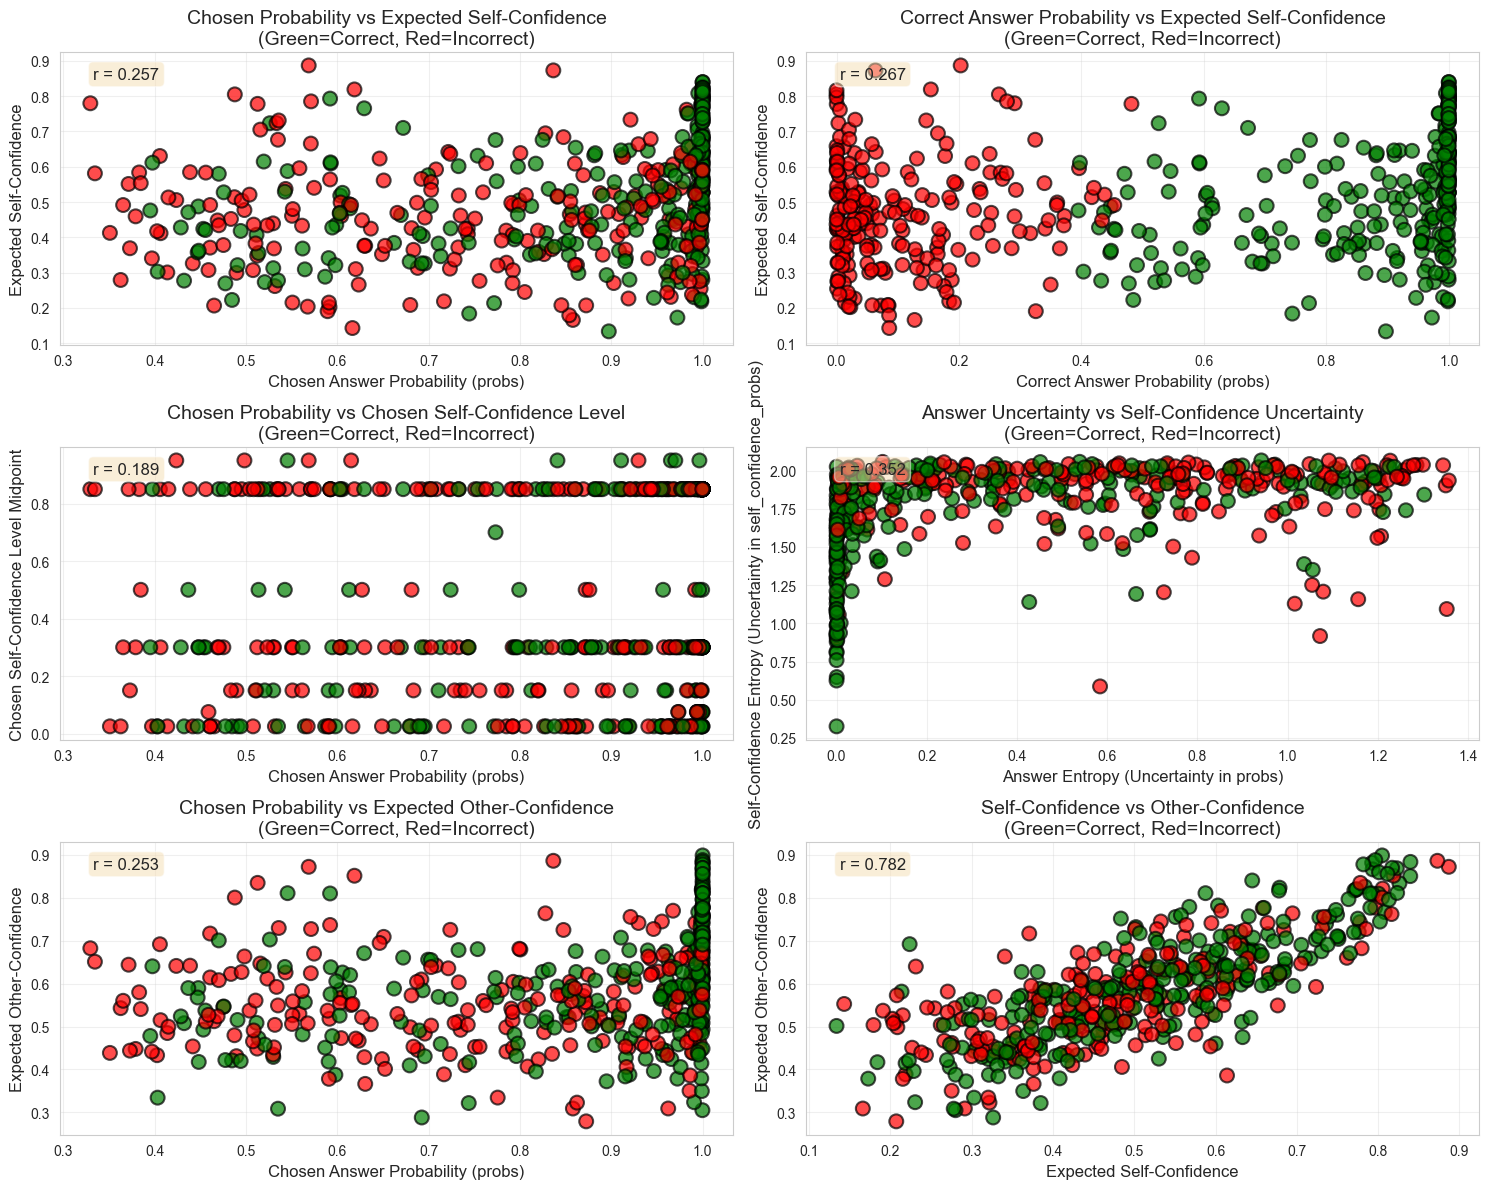

In [4]:
# Visualization 1: Relationship between probs and confidence_probs
has_other = df['expected_other_confidence'].notna().any()
n_rows = 3 if has_other else 2
fig, axes = plt.subplots(n_rows, 2, figsize=(15, 12 if has_other else 12))

# 1. Chosen probability vs Expected self-confidence
ax = axes[0, 0]
scatter = ax.scatter(df['chosen_prob'], df['expected_self_confidence'], 
                     c=df['is_correct'].map({True: 'green', False: 'red'}),
                     s=100, alpha=0.7, edgecolors='black', linewidth=1.5)
ax.set_xlabel('Chosen Answer Probability (probs)', fontsize=12)
ax.set_ylabel('Expected Self-Confidence', fontsize=12)
ax.set_title('Chosen Probability vs Expected Self-Confidence\n(Green=Correct, Red=Incorrect)', fontsize=14)
ax.grid(True, alpha=0.3)
# Add correlation text
corr = df['chosen_prob'].corr(df['expected_self_confidence'])
ax.text(0.05, 0.95, f'r = {corr:.3f}', transform=ax.transAxes, 
        fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. Correct probability vs Expected self-confidence
ax = axes[0, 1]
scatter = ax.scatter(df['correct_prob'], df['expected_self_confidence'], 
                     c=df['is_correct'].map({True: 'green', False: 'red'}),
                     s=100, alpha=0.7, edgecolors='black', linewidth=1.5)
ax.set_xlabel('Correct Answer Probability (probs)', fontsize=12)
ax.set_ylabel('Expected Self-Confidence', fontsize=12)
ax.set_title('Correct Answer Probability vs Expected Self-Confidence\n(Green=Correct, Red=Incorrect)', fontsize=14)
ax.grid(True, alpha=0.3)
corr_correct = df['correct_prob'].corr(df['expected_self_confidence'])
ax.text(0.05, 0.95, f'r = {corr_correct:.3f}', transform=ax.transAxes, 
        fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 3. Chosen probability vs Self-confidence midpoint (chosen confidence level)
ax = axes[1, 0]
scatter = ax.scatter(df['chosen_prob'], df['self_confidence_midpoint'], 
                     c=df['is_correct'].map({True: 'green', False: 'red'}),
                     s=100, alpha=0.7, edgecolors='black', linewidth=1.5)
ax.set_xlabel('Chosen Answer Probability (probs)', fontsize=12)
ax.set_ylabel('Chosen Self-Confidence Level Midpoint', fontsize=12)
ax.set_title('Chosen Probability vs Chosen Self-Confidence Level\n(Green=Correct, Red=Incorrect)', fontsize=14)
ax.grid(True, alpha=0.3)
corr_midpoint = df['chosen_prob'].corr(df['self_confidence_midpoint'])
ax.text(0.05, 0.95, f'r = {corr_midpoint:.3f}', transform=ax.transAxes, 
        fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 4. Answer entropy vs Self-confidence entropy
ax = axes[1, 1]
scatter = ax.scatter(df['answer_entropy'], df['self_confidence_entropy'], 
                     c=df['is_correct'].map({True: 'green', False: 'red'}),
                     s=100, alpha=0.7, edgecolors='black', linewidth=1.5)
ax.set_xlabel('Answer Entropy (Uncertainty in probs)', fontsize=12)
ax.set_ylabel('Self-Confidence Entropy (Uncertainty in self_confidence_probs)', fontsize=12)
ax.set_title('Answer Uncertainty vs Self-Confidence Uncertainty\n(Green=Correct, Red=Incorrect)', fontsize=14)
ax.grid(True, alpha=0.3)
corr_entropy = df['answer_entropy'].corr(df['self_confidence_entropy'])
ax.text(0.05, 0.95, f'r = {corr_entropy:.3f}', transform=ax.transAxes, 
        fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 5-6. Other-confidence visualizations (if available)
if has_other:
    # 5. Chosen probability vs Expected other-confidence
    ax = axes[2, 0]
    df_other = df[df['expected_other_confidence'].notna()]
    scatter = ax.scatter(df_other['chosen_prob'], df_other['expected_other_confidence'], 
                         c=df_other['is_correct'].map({True: 'green', False: 'red'}),
                         s=100, alpha=0.7, edgecolors='black', linewidth=1.5)
    ax.set_xlabel('Chosen Answer Probability (probs)', fontsize=12)
    ax.set_ylabel('Expected Other-Confidence', fontsize=12)
    ax.set_title('Chosen Probability vs Expected Other-Confidence\n(Green=Correct, Red=Incorrect)', fontsize=14)
    ax.grid(True, alpha=0.3)
    corr_other = df_other['chosen_prob'].corr(df_other['expected_other_confidence'])
    ax.text(0.05, 0.95, f'r = {corr_other:.3f}', transform=ax.transAxes, 
            fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # 6. Self-confidence vs Other-confidence
    ax = axes[2, 1]
    df_other = df[df['expected_other_confidence'].notna()]
    scatter = ax.scatter(df_other['expected_self_confidence'], df_other['expected_other_confidence'], 
                         c=df_other['is_correct'].map({True: 'green', False: 'red'}),
                         s=100, alpha=0.7, edgecolors='black', linewidth=1.5)
    ax.set_xlabel('Expected Self-Confidence', fontsize=12)
    ax.set_ylabel('Expected Other-Confidence', fontsize=12)
    ax.set_title('Self-Confidence vs Other-Confidence\n(Green=Correct, Red=Incorrect)', fontsize=14)
    ax.grid(True, alpha=0.3)
    corr_self_other = df_other['expected_self_confidence'].corr(df_other['expected_other_confidence'])
    ax.text(0.05, 0.95, f'r = {corr_self_other:.3f}', transform=ax.transAxes, 
            fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()


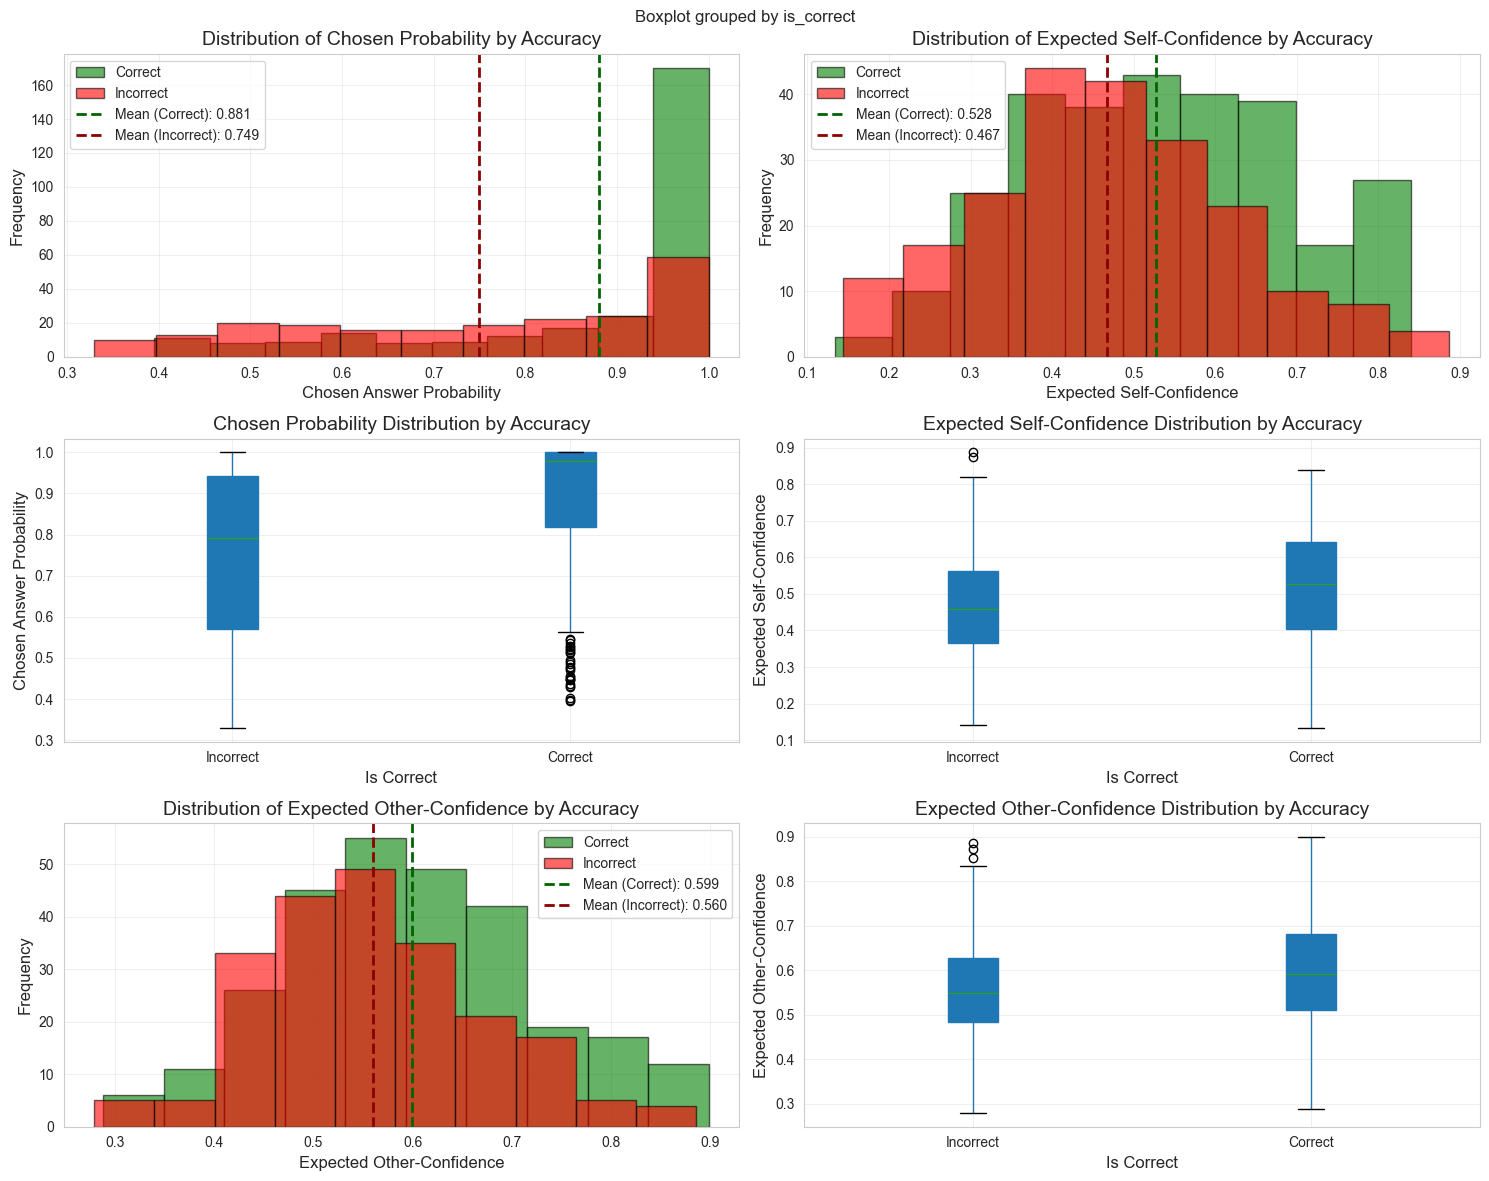

In [5]:
# Visualization 2: Relationship with accuracy
has_other = df['expected_other_confidence'].notna().any()
n_rows = 3 if has_other else 2
fig, axes = plt.subplots(n_rows, 2, figsize=(15, 12 if has_other else 12))

# 1. Distribution of chosen_prob by accuracy
ax = axes[0, 0]
correct_probs = df[df['is_correct']]['chosen_prob']
incorrect_probs = df[~df['is_correct']]['chosen_prob']
ax.hist(correct_probs, bins=10, alpha=0.6, label='Correct', color='green', edgecolor='black')
ax.hist(incorrect_probs, bins=10, alpha=0.6, label='Incorrect', color='red', edgecolor='black')
ax.set_xlabel('Chosen Answer Probability', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Chosen Probability by Accuracy', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
# Add mean lines
ax.axvline(correct_probs.mean(), color='darkgreen', linestyle='--', linewidth=2, label=f'Mean (Correct): {correct_probs.mean():.3f}')
ax.axvline(incorrect_probs.mean(), color='darkred', linestyle='--', linewidth=2, label=f'Mean (Incorrect): {incorrect_probs.mean():.3f}')
ax.legend()

# 2. Distribution of expected_self_confidence by accuracy
ax = axes[0, 1]
correct_conf = df[df['is_correct']]['expected_self_confidence']
incorrect_conf = df[~df['is_correct']]['expected_self_confidence']
ax.hist(correct_conf, bins=10, alpha=0.6, label='Correct', color='green', edgecolor='black')
ax.hist(incorrect_conf, bins=10, alpha=0.6, label='Incorrect', color='red', edgecolor='black')
ax.set_xlabel('Expected Self-Confidence', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Expected Self-Confidence by Accuracy', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
ax.axvline(correct_conf.mean(), color='darkgreen', linestyle='--', linewidth=2, label=f'Mean (Correct): {correct_conf.mean():.3f}')
ax.axvline(incorrect_conf.mean(), color='darkred', linestyle='--', linewidth=2, label=f'Mean (Incorrect): {incorrect_conf.mean():.3f}')
ax.legend()

# 3. Box plot: chosen_prob by accuracy
ax = axes[1, 0]
df.boxplot(column='chosen_prob', by='is_correct', ax=ax, patch_artist=True)
ax.set_xlabel('Is Correct', fontsize=12)
ax.set_ylabel('Chosen Answer Probability', fontsize=12)
ax.set_title('Chosen Probability Distribution by Accuracy', fontsize=14)
ax.set_xticklabels(['Incorrect', 'Correct'])
ax.grid(True, alpha=0.3)

# 4. Box plot: expected_self_confidence by accuracy
ax = axes[1, 1]
df.boxplot(column='expected_self_confidence', by='is_correct', ax=ax, patch_artist=True)
ax.set_xlabel('Is Correct', fontsize=12)
ax.set_ylabel('Expected Self-Confidence', fontsize=12)
ax.set_title('Expected Self-Confidence Distribution by Accuracy', fontsize=14)
ax.set_xticklabels(['Incorrect', 'Correct'])
ax.grid(True, alpha=0.3)

# 5-6. Other-confidence distributions (if available)
if has_other:
    # 5. Distribution of expected_other_confidence by accuracy
    ax = axes[2, 0]
    df_other = df[df['expected_other_confidence'].notna()]
    correct_conf_other = df_other[df_other['is_correct']]['expected_other_confidence']
    incorrect_conf_other = df_other[~df_other['is_correct']]['expected_other_confidence']
    ax.hist(correct_conf_other, bins=10, alpha=0.6, label='Correct', color='green', edgecolor='black')
    ax.hist(incorrect_conf_other, bins=10, alpha=0.6, label='Incorrect', color='red', edgecolor='black')
    ax.set_xlabel('Expected Other-Confidence', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title('Distribution of Expected Other-Confidence by Accuracy', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axvline(correct_conf_other.mean(), color='darkgreen', linestyle='--', linewidth=2, label=f'Mean (Correct): {correct_conf_other.mean():.3f}')
    ax.axvline(incorrect_conf_other.mean(), color='darkred', linestyle='--', linewidth=2, label=f'Mean (Incorrect): {incorrect_conf_other.mean():.3f}')
    ax.legend()
    
    # 6. Box plot: expected_other_confidence by accuracy
    ax = axes[2, 1]
    df_other.boxplot(column='expected_other_confidence', by='is_correct', ax=ax, patch_artist=True)
    ax.set_xlabel('Is Correct', fontsize=12)
    ax.set_ylabel('Expected Other-Confidence', fontsize=12)
    ax.set_title('Expected Other-Confidence Distribution by Accuracy', fontsize=14)
    ax.set_xticklabels(['Incorrect', 'Correct'])
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


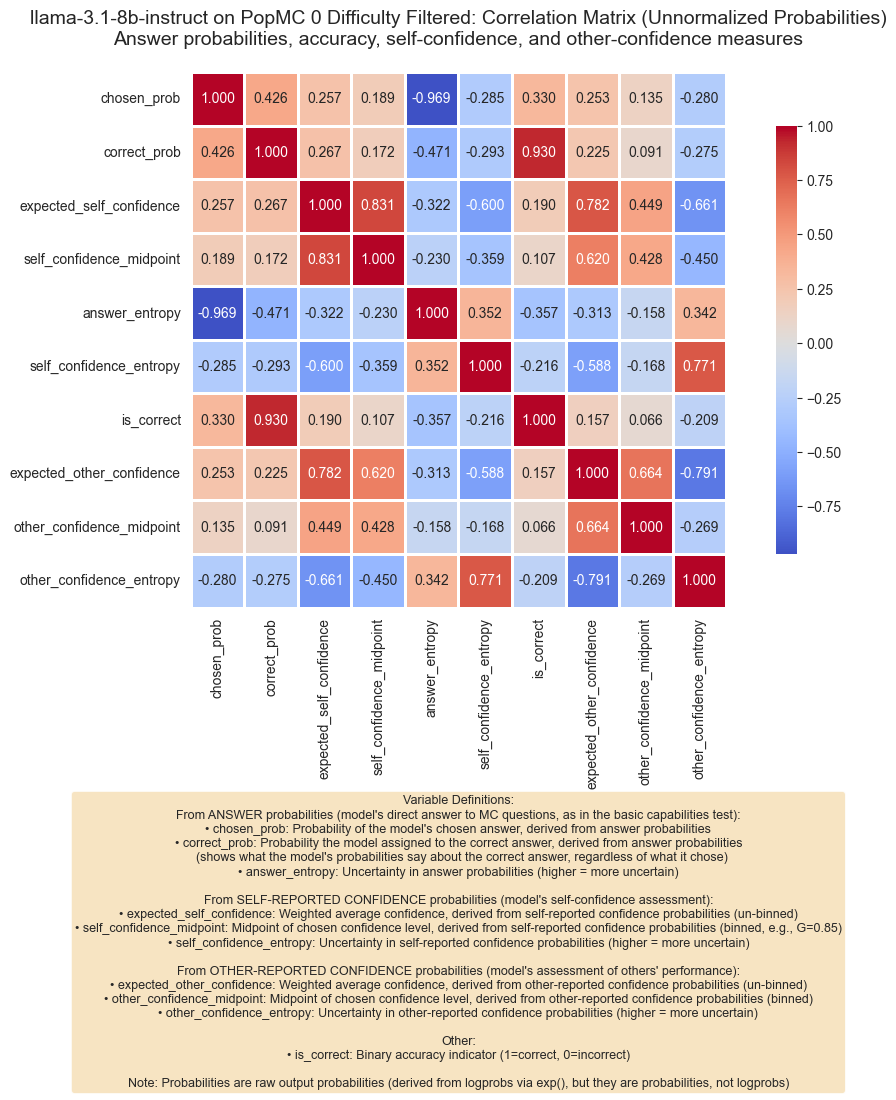

In [6]:
# Correlation matrix
# Variable explanations:
# Variables from ANSWER probabilities (model's direct answer to the question):
# - chosen_prob: Probability of the answer the model chose, derived from answer probabilities
# - correct_prob: Probability that the model assigned to the correct answer, derived from answer probabilities (regardless of what it chose)
# - answer_entropy: Entropy/uncertainty in the answer probabilities (higher = more uncertain)
#
# Variables from SELF-REPORTED CONFIDENCE probabilities (model's self-confidence assessment):
# - expected_self_confidence: Weighted average of confidence levels, derived from self-reported confidence probabilities (un-binned)
# - self_confidence_midpoint: Midpoint of the chosen confidence level, derived from self-reported confidence probabilities (binned, e.g., G = 0.85 for 80-90%)
# - self_confidence_entropy: Entropy/uncertainty in the self-reported confidence probabilities (higher = more uncertain)
#
# Variables from OTHER-REPORTED CONFIDENCE probabilities (model's assessment of others' performance):
# - expected_other_confidence: Weighted average of confidence levels, derived from other-reported confidence probabilities (un-binned)
# - other_confidence_midpoint: Midpoint of the chosen confidence level, derived from other-reported confidence probabilities (binned)
# - other_confidence_entropy: Entropy/uncertainty in the other-reported confidence probabilities (higher = more uncertain)
#
# Other:
# - is_correct: Binary indicator (1 = correct, 0 = incorrect)

fig, ax = plt.subplots(figsize=(12, 10))
correlation_vars = ['chosen_prob', 'correct_prob', 'expected_self_confidence', 
                     'self_confidence_midpoint', 'answer_entropy', 'self_confidence_entropy', 'is_correct']
# Add other-confidence variables if available
if df['expected_other_confidence'].notna().any():
    correlation_vars.extend(['expected_other_confidence', 'other_confidence_midpoint', 'other_confidence_entropy'])
corr_matrix = df[correlation_vars].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title(f'{model_name} on {dataset_name}: Correlation Matrix (Unnormalized Probabilities)\nAnswer probabilities, accuracy, self-confidence, and other-confidence measures', fontsize=14, pad=20)

# Add legend below the plot
legend_text = (
    "Variable Definitions:\n"
    "From ANSWER probabilities (model's direct answer to MC questions, as in the basic capabilities test):\n"
    "• chosen_prob: Probability of the model's chosen answer, derived from answer probabilities\n"
    "• correct_prob: Probability the model assigned to the correct answer, derived from answer probabilities\n"
    "  (shows what the model's probabilities say about the correct answer, regardless of what it chose)\n"
    "• answer_entropy: Uncertainty in answer probabilities (higher = more uncertain)\n"
    "\n"
    "From SELF-REPORTED CONFIDENCE probabilities (model's self-confidence assessment):\n"
    "• expected_self_confidence: Weighted average confidence, derived from self-reported confidence probabilities (un-binned)\n"
    "• self_confidence_midpoint: Midpoint of chosen confidence level, derived from self-reported confidence probabilities (binned, e.g., G=0.85)\n"
    "• self_confidence_entropy: Uncertainty in self-reported confidence probabilities (higher = more uncertain)\n"
)
if df['expected_other_confidence'].notna().any():
    legend_text += (
        "\n"
        "From OTHER-REPORTED CONFIDENCE probabilities (model's assessment of others' performance):\n"
        "• expected_other_confidence: Weighted average confidence, derived from other-reported confidence probabilities (un-binned)\n"
        "• other_confidence_midpoint: Midpoint of chosen confidence level, derived from other-reported confidence probabilities (binned)\n"
        "• other_confidence_entropy: Uncertainty in other-reported confidence probabilities (higher = more uncertain)\n"
    )
legend_text += (
    "\n"
    "Other:\n"
    "• is_correct: Binary accuracy indicator (1=correct, 0=incorrect)\n"
    "\n"
    "Note: Probabilities are raw output probabilities (derived from logprobs via exp(), but they are probabilities, not logprobs)"
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.40 if df['expected_other_confidence'].notna().any() else 0.35)  # Make room for legend below labels
ax.text(0.5, -0.35 if df['expected_other_confidence'].notna().any() else -0.30, legend_text, transform=ax.transAxes, 
        fontsize=9, ha='center', va='top', 
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
plt.show()


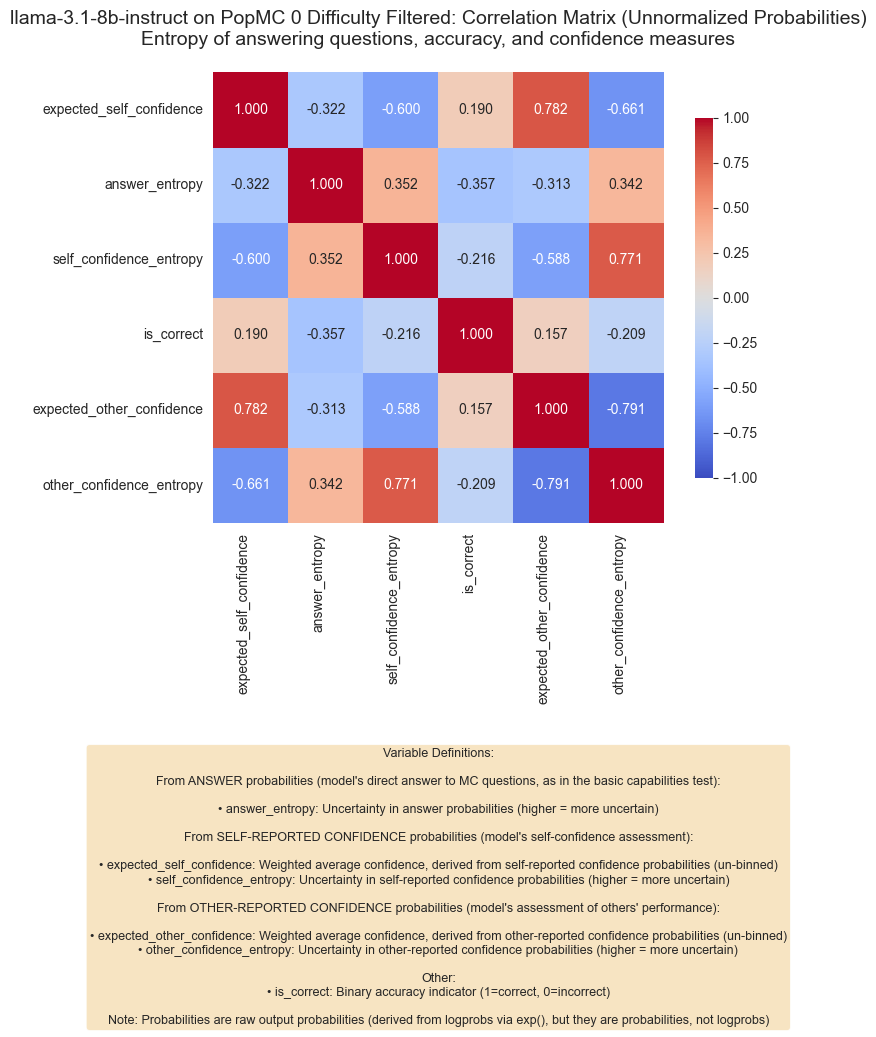

In [7]:
# Simplified correlation matrix: Confidence and Uncertainty measures
# Variable explanations:
# Variables from ANSWER probabilities (model's direct answer to the question):
# - answer_entropy: Entropy/uncertainty in the answer probabilities (higher = more uncertain)
#
# Variables from SELF-REPORTED CONFIDENCE probabilities (model's self-confidence assessment):
# - expected_self_confidence: Weighted average of confidence levels, derived from self-reported confidence probabilities (un-binned)
# - self_confidence_entropy: Entropy/uncertainty in the self-reported confidence probabilities (higher = more uncertain)
#
# Variables from OTHER-REPORTED CONFIDENCE probabilities (model's assessment of others' performance):
# - expected_other_confidence: Weighted average of confidence levels, derived from other-reported confidence probabilities (un-binned)
# - other_confidence_entropy: Entropy/uncertainty in the other-reported confidence probabilities (higher = more uncertain)
#
# Other:
# - is_correct: Binary indicator (1 = correct, 0 = incorrect)

fig, ax = plt.subplots(figsize=(8, 6))
correlation_vars = ['expected_self_confidence', 'answer_entropy', 'self_confidence_entropy', 'is_correct']
# Add other-confidence variables if available
if df['expected_other_confidence'].notna().any():
    correlation_vars.extend(['expected_other_confidence', 'other_confidence_entropy'])
corr_matrix = df[correlation_vars].corr()

sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            vmin=-1, vmax=1, square=True, linewidths=0, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title(f'{model_name} on {dataset_name}: Correlation Matrix (Unnormalized Probabilities)\nEntropy of answering questions, accuracy, and confidence measures', fontsize=14, pad=20)
# Rotate labels to be perpendicular (like the full correlation matrix)
plt.setp(ax.get_xticklabels(), rotation=90, ha='right')
plt.setp(ax.get_yticklabels(), rotation=0)

# Add legend below the plot
legend_text = (
    "Variable Definitions:\n"
    "\n"
    "From ANSWER probabilities (model's direct answer to MC questions, as in the basic capabilities test):\n"
    "\n"
    "• answer_entropy: Uncertainty in answer probabilities (higher = more uncertain)\n"
    "\n"
    "From SELF-REPORTED CONFIDENCE probabilities (model's self-confidence assessment):\n"
    "\n"
    "• expected_self_confidence: Weighted average confidence, derived from self-reported confidence probabilities (un-binned)\n"
    "• self_confidence_entropy: Uncertainty in self-reported confidence probabilities (higher = more uncertain)\n"
)
if df['expected_other_confidence'].notna().any():
    legend_text += (
        "\n"
        "From OTHER-REPORTED CONFIDENCE probabilities (model's assessment of others' performance):\n"
        "\n"
        "• expected_other_confidence: Weighted average confidence, derived from other-reported confidence probabilities (un-binned)\n"
        "• other_confidence_entropy: Uncertainty in other-reported confidence probabilities (higher = more uncertain)\n"
    )
legend_text += (
    "\n"
    "Other:\n"
    "• is_correct: Binary accuracy indicator (1=correct, 0=incorrect)\n"
    "\n"
    "Note: Probabilities are raw output probabilities (derived from logprobs via exp(), but they are probabilities, not logprobs)"
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.12 if df['expected_other_confidence'].notna().any() else 0.090)  # Make room for legend below labels
ax.text(0.5, -0.50 if df['expected_other_confidence'].notna().any() else -0.45, legend_text, transform=ax.transAxes, 
        fontsize=9, ha='center', va='top', 
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
plt.show()


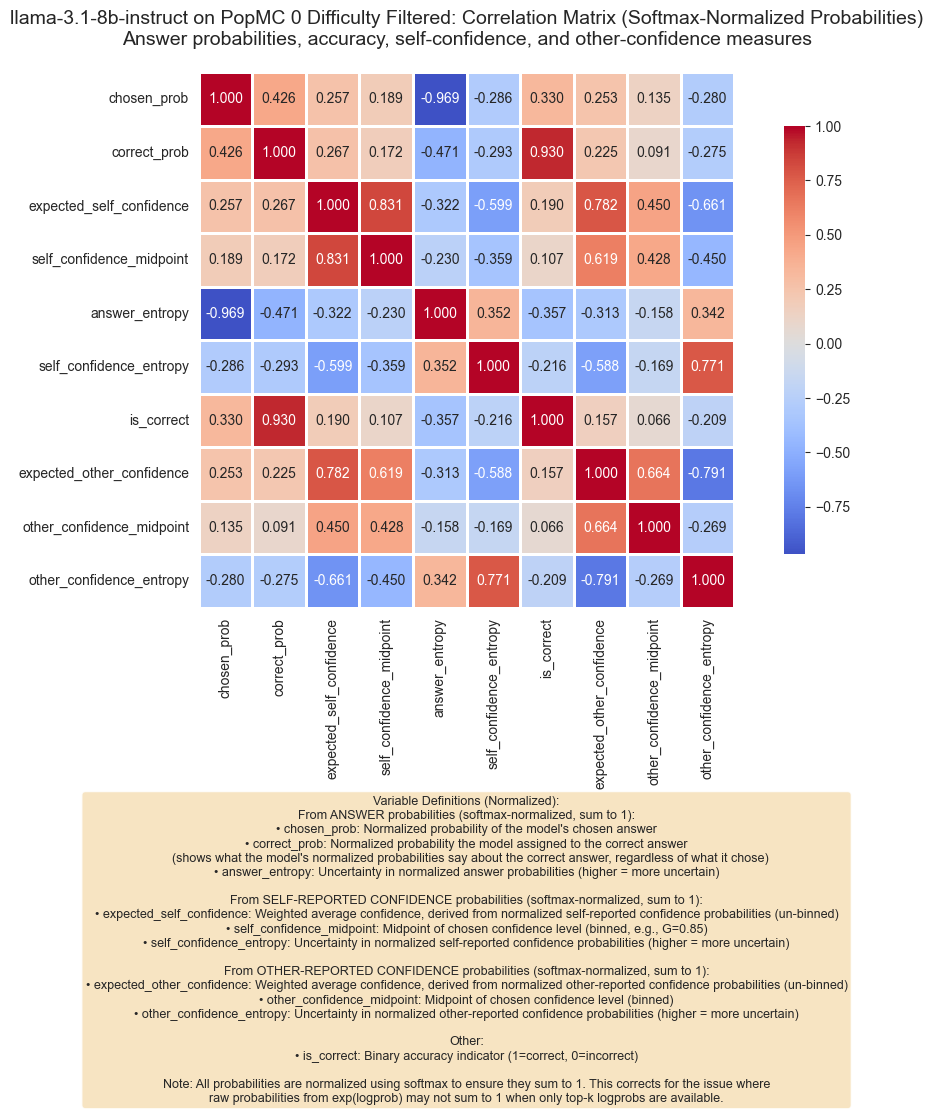

In [8]:
# Correlation matrix with SOFTMAX-NORMALIZED probabilities
# This uses probabilities that have been normalized using softmax to ensure they sum to 1
# Compare this with the unnormalized correlation matrix above to see the impact of normalization

# Create a temporary dataframe with clean column names (no _norm suffix) for visualization
# Map normalized columns to clean names, keeping non-normalized columns as-is
base_cols = ['is_correct', 'self_confidence_midpoint']
if 'other_confidence_midpoint' in df.columns:
    base_cols.append('other_confidence_midpoint')
df_norm_clean = df[base_cols].copy()
# Add normalized columns with clean names
if 'chosen_prob_norm' in df.columns:
    df_norm_clean['chosen_prob'] = df['chosen_prob_norm']
if 'correct_prob_norm' in df.columns:
    df_norm_clean['correct_prob'] = df['correct_prob_norm']
if 'expected_self_confidence_norm' in df.columns:
    df_norm_clean['expected_self_confidence'] = df['expected_self_confidence_norm']
if 'answer_entropy_norm' in df.columns:
    df_norm_clean['answer_entropy'] = df['answer_entropy_norm']
if 'self_confidence_entropy_norm' in df.columns:
    df_norm_clean['self_confidence_entropy'] = df['self_confidence_entropy_norm']
if 'expected_other_confidence_norm' in df.columns:
    df_norm_clean['expected_other_confidence'] = df['expected_other_confidence_norm']
if 'other_confidence_entropy_norm' in df.columns:
    df_norm_clean['other_confidence_entropy'] = df['other_confidence_entropy_norm']

fig, ax = plt.subplots(figsize=(12, 10))
correlation_vars_norm = ['chosen_prob', 'correct_prob', 'expected_self_confidence', 
                         'self_confidence_midpoint', 'answer_entropy', 'self_confidence_entropy', 'is_correct']
# Add other-confidence variables if available
if 'expected_other_confidence' in df_norm_clean.columns and df_norm_clean['expected_other_confidence'].notna().any():
    correlation_vars_norm.extend(['expected_other_confidence', 'other_confidence_midpoint', 'other_confidence_entropy'])
corr_matrix_norm = df_norm_clean[correlation_vars_norm].corr()
sns.heatmap(corr_matrix_norm, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title(f'{model_name} on {dataset_name}: Correlation Matrix (Softmax-Normalized Probabilities)\nAnswer probabilities, accuracy, self-confidence, and other-confidence measures', fontsize=14, pad=20)

# Add legend below the plot
legend_text = (
    "Variable Definitions (Normalized):\n"
    "From ANSWER probabilities (softmax-normalized, sum to 1):\n"
    "• chosen_prob: Normalized probability of the model's chosen answer\n"
    "• correct_prob: Normalized probability the model assigned to the correct answer\n"
    "  (shows what the model's normalized probabilities say about the correct answer, regardless of what it chose)\n"
    "• answer_entropy: Uncertainty in normalized answer probabilities (higher = more uncertain)\n"
    "\n"
    "From SELF-REPORTED CONFIDENCE probabilities (softmax-normalized, sum to 1):\n"
    "• expected_self_confidence: Weighted average confidence, derived from normalized self-reported confidence probabilities (un-binned)\n"
    "• self_confidence_midpoint: Midpoint of chosen confidence level (binned, e.g., G=0.85)\n"
    "• self_confidence_entropy: Uncertainty in normalized self-reported confidence probabilities (higher = more uncertain)\n"
)
if df['expected_other_confidence_norm'].notna().any():
    legend_text += (
        "\n"
        "From OTHER-REPORTED CONFIDENCE probabilities (softmax-normalized, sum to 1):\n"
        "• expected_other_confidence: Weighted average confidence, derived from normalized other-reported confidence probabilities (un-binned)\n"
        "• other_confidence_midpoint: Midpoint of chosen confidence level (binned)\n"
        "• other_confidence_entropy: Uncertainty in normalized other-reported confidence probabilities (higher = more uncertain)\n"
    )
legend_text += (
    "\n"
    "Other:\n"
    "• is_correct: Binary accuracy indicator (1=correct, 0=incorrect)\n"
    "\n"
    "Note: All probabilities are normalized using softmax to ensure they sum to 1. This corrects for the issue where\n"
    "raw probabilities from exp(logprob) may not sum to 1 when only top-k logprobs are available."
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.40 if df['expected_other_confidence_norm'].notna().any() else 0.35)  # Make room for legend below labels
ax.text(0.5, -0.35 if df['expected_other_confidence_norm'].notna().any() else -0.30, legend_text, transform=ax.transAxes, 
        fontsize=9, ha='center', va='top', 
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
plt.show()


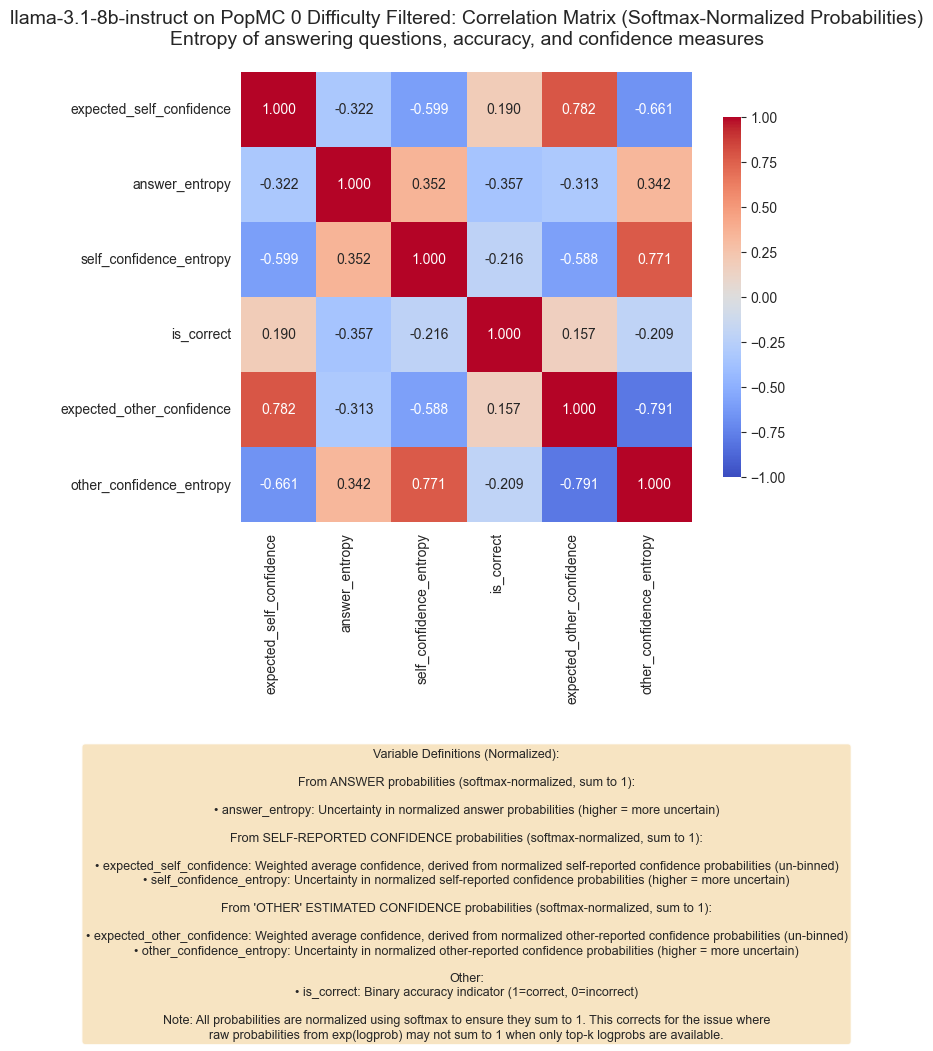

In [9]:
# Simplified correlation matrix with SOFTMAX-NORMALIZED probabilities: Confidence and Uncertainty measures
# Create clean dataframe with normalized columns (no _norm suffix for cleaner visualization)
base_cols = ['is_correct', 'self_confidence_midpoint']
if 'other_confidence_midpoint' in df.columns:
    base_cols.append('other_confidence_midpoint')
df_norm_clean_simple = df[base_cols].copy()
if 'expected_self_confidence_norm' in df.columns:
    df_norm_clean_simple['expected_self_confidence'] = df['expected_self_confidence_norm']
if 'answer_entropy_norm' in df.columns:
    df_norm_clean_simple['answer_entropy'] = df['answer_entropy_norm']
if 'self_confidence_entropy_norm' in df.columns:
    df_norm_clean_simple['self_confidence_entropy'] = df['self_confidence_entropy_norm']
if 'expected_other_confidence_norm' in df.columns:
    df_norm_clean_simple['expected_other_confidence'] = df['expected_other_confidence_norm']
if 'other_confidence_entropy_norm' in df.columns:
    df_norm_clean_simple['other_confidence_entropy'] = df['other_confidence_entropy_norm']

fig, ax = plt.subplots(figsize=(8, 6))
correlation_vars_norm_simple = ['expected_self_confidence', 'answer_entropy', 'self_confidence_entropy', 'is_correct']
# Add other-confidence variables if available
if 'expected_other_confidence' in df_norm_clean_simple.columns and df_norm_clean_simple['expected_other_confidence'].notna().any():
    correlation_vars_norm_simple.extend(['expected_other_confidence', 'other_confidence_entropy'])
corr_matrix_norm_simple = df_norm_clean_simple[correlation_vars_norm_simple].corr()

sns.heatmap(corr_matrix_norm_simple, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            vmin=-1, vmax=1, square=True, linewidths=0, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title(f'{model_name} on {dataset_name}: Correlation Matrix (Softmax-Normalized Probabilities)\nEntropy of answering questions, accuracy, and confidence measures', fontsize=14, pad=20)
# Rotate labels to be perpendicular (like the full correlation matrix)
plt.setp(ax.get_xticklabels(), rotation=90, ha='right')
plt.setp(ax.get_yticklabels(), rotation=0)

# Add legend below the plot
legend_text = (
    "Variable Definitions (Normalized):\n"
    "\n"
    "From ANSWER probabilities (softmax-normalized, sum to 1):\n"
    "\n"
    "• answer_entropy: Uncertainty in normalized answer probabilities (higher = more uncertain)\n"
    "\n"
    "From SELF-REPORTED CONFIDENCE probabilities (softmax-normalized, sum to 1):\n"
    "\n"
    "• expected_self_confidence: Weighted average confidence, derived from normalized self-reported confidence probabilities (un-binned)\n"
    "• self_confidence_entropy: Uncertainty in normalized self-reported confidence probabilities (higher = more uncertain)\n"
)
if df['expected_other_confidence_norm'].notna().any():
    legend_text += (
        "\n"
        "From 'OTHER' ESTIMATED CONFIDENCE probabilities (softmax-normalized, sum to 1):\n"
        "\n"
        "• expected_other_confidence: Weighted average confidence, derived from normalized other-reported confidence probabilities (un-binned)\n"
        "• other_confidence_entropy: Uncertainty in normalized other-reported confidence probabilities (higher = more uncertain)\n"
    )
legend_text += (
    "\n"
    "Other:\n"
    "• is_correct: Binary accuracy indicator (1=correct, 0=incorrect)\n"
    "\n"
    "Note: All probabilities are normalized using softmax to ensure they sum to 1. This corrects for the issue where\n"
    "raw probabilities from exp(logprob) may not sum to 1 when only top-k logprobs are available."
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.12 if df['expected_other_confidence_norm'].notna().any() else 0.090)  # Make room for legend below labels
ax.text(0.5, -0.50 if df['expected_other_confidence_norm'].notna().any() else -0.45, legend_text, transform=ax.transAxes, 
        fontsize=9, ha='center', va='top', 
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
plt.show()


# Analyzing divergence of self-confidence vs estimation of other's confidence. Is the model introspecting?

CORRELATION MATRIX ANALYSIS

Correlation Matrix:
                           expected_self_confidence  \
expected_self_confidence                      1.000   
expected_other_confidence                     0.782   
chosen_prob                                   0.257   
answer_entropy                               -0.322   

                           expected_other_confidence  chosen_prob  \
expected_self_confidence                       0.782        0.257   
expected_other_confidence                      1.000        0.253   
chosen_prob                                    0.253        1.000   
answer_entropy                                -0.313       -0.969   

                           answer_entropy  
expected_self_confidence           -0.322  
expected_other_confidence          -0.313  
chosen_prob                        -0.969  
answer_entropy                      1.000  

--------------------------------------------------------------------------------
KEY CORRELATIONS:
---------

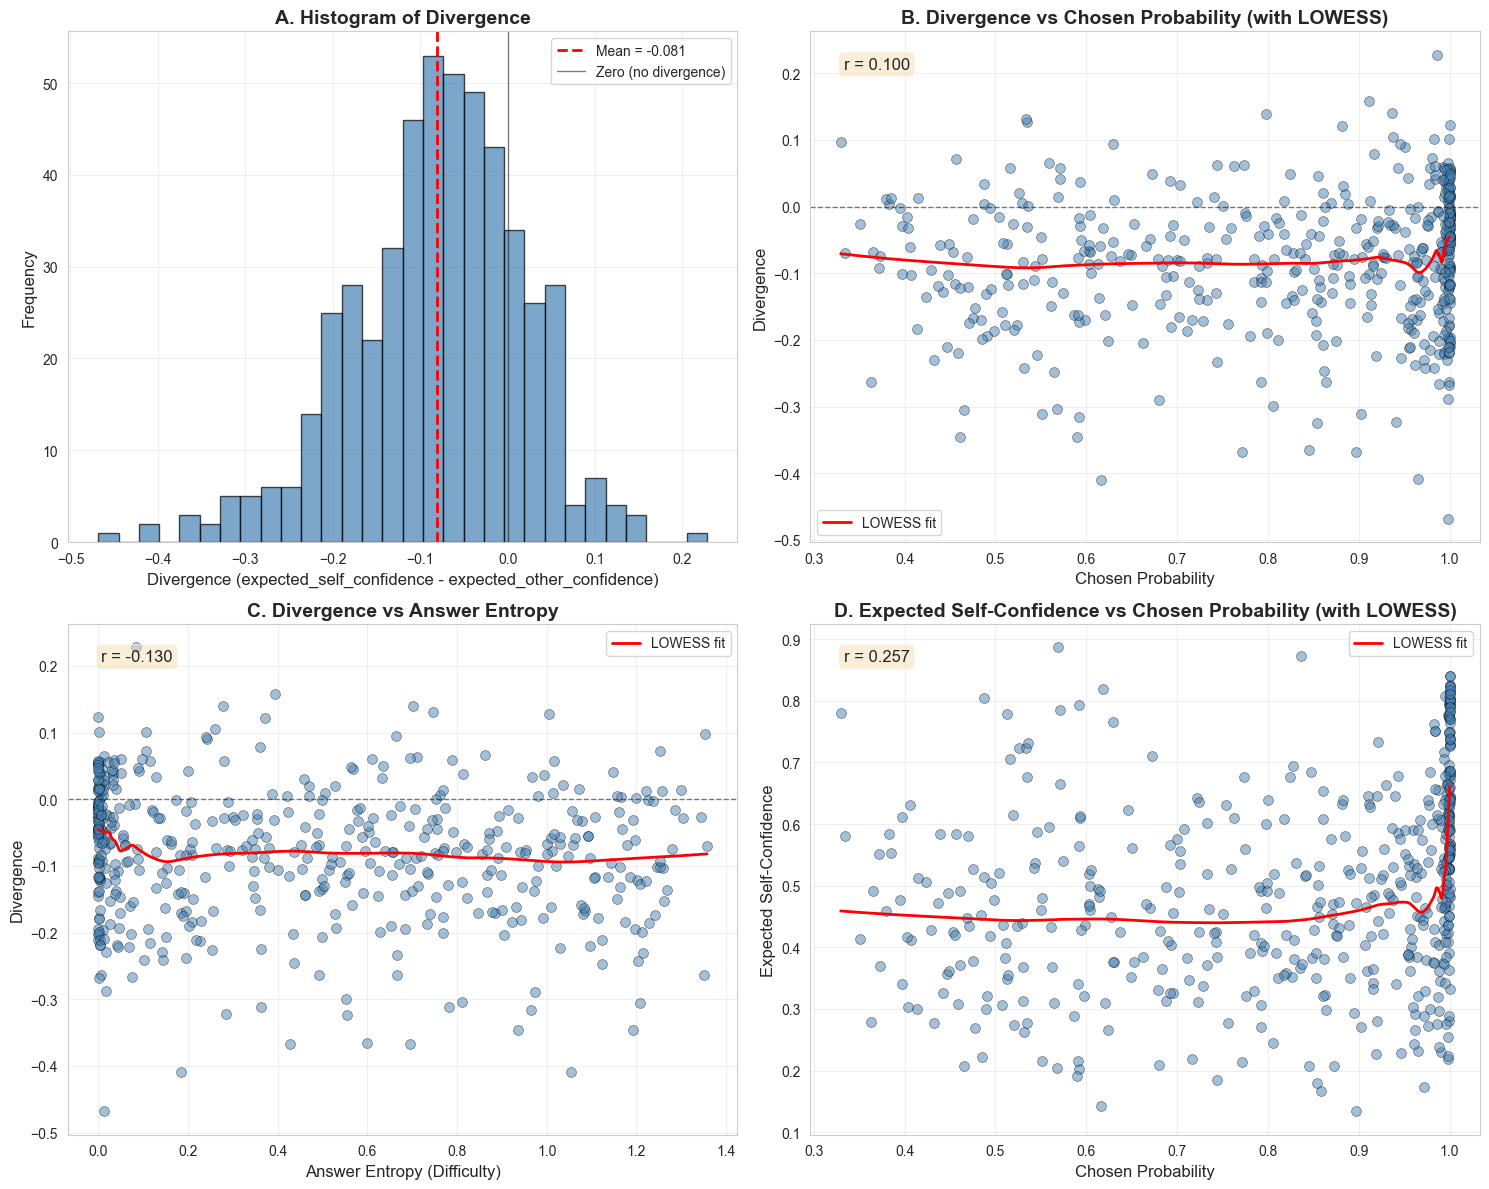

In [10]:
# Correlation matrix and partial correlation analysis
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.regression.linear_model import OLS
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("CORRELATION MATRIX ANALYSIS")
print("=" * 80)

# 1. Create correlation matrix for key relationships
corr_vars = ['expected_self_confidence', 'expected_other_confidence', 'chosen_prob', 'answer_entropy']
# Filter to only include variables that exist and have data
available_vars = [var for var in corr_vars if var in df.columns and df[var].notna().any()]

# Check if expected_other_confidence has data
has_other_confidence = 'expected_other_confidence' in df.columns and df['expected_other_confidence'].notna().any()

if has_other_confidence:
    corr_matrix = df[available_vars].corr()
    print("\nCorrelation Matrix:")
    print(corr_matrix.round(3))
    
    # Extract specific correlations
    print("\n" + "-" * 80)
    print("KEY CORRELATIONS:")
    print("-" * 80)
    print(f"corr(expected_self_confidence, chosen_prob) = {df['expected_self_confidence'].corr(df['chosen_prob']):.3f}")
    print(f"corr(expected_other_confidence, chosen_prob) = {df['expected_other_confidence'].corr(df['chosen_prob']):.3f}")
    print(f"corr(expected_self_confidence, expected_other_confidence) = {df['expected_self_confidence'].corr(df['expected_other_confidence']):.3f}")
    print(f"corr(expected_self_confidence, answer_entropy) = {df['expected_self_confidence'].corr(df['answer_entropy']):.3f}")
else:
    # If no other_confidence data, just show available correlations
    corr_matrix = df[available_vars].corr()
    print("\nCorrelation Matrix:")
    print(corr_matrix.round(3))
    
    print("\n" + "-" * 80)
    print("KEY CORRELATIONS:")
    print("-" * 80)
    print(f"corr(expected_self_confidence, chosen_prob) = {df['expected_self_confidence'].corr(df['chosen_prob']):.3f}")
    print(f"corr(expected_self_confidence, answer_entropy) = {df['expected_self_confidence'].corr(df['answer_entropy']):.3f}")
    print("Note: expected_other_confidence not available in this dataset")

# 2. Partial correlations controlling for answer_entropy (difficulty)
print("\n" + "=" * 80)
print("PARTIAL CORRELATIONS (controlling for answer_entropy)")
print("=" * 80)

def partial_correlation(x, y, z):
    """
    Compute partial correlation between x and y controlling for z.
    Method: Regress x on z and y on z, then correlate the residuals.
    """
    # Remove NaN values
    valid_idx = ~(pd.isna(x) | pd.isna(y) | pd.isna(z))
    x_clean = x[valid_idx]
    y_clean = y[valid_idx]
    z_clean = z[valid_idx]
    
    if len(x_clean) < 3:
        return np.nan, np.nan
    
    # Regress x on z
    z_const = np.column_stack([np.ones(len(z_clean)), z_clean])
    model_x = OLS(x_clean, z_const).fit()
    residuals_x = model_x.resid
    
    # Regress y on z
    model_y = OLS(y_clean, z_const).fit()
    residuals_y = model_y.resid
    
    # Correlate residuals
    partial_r = np.corrcoef(residuals_x, residuals_y)[0, 1]
    
    # Compute p-value using t-test
    n = len(residuals_x)
    if abs(partial_r) < 1.0 and n > 3:
        t_stat = partial_r * np.sqrt((n - 2) / (1 - partial_r**2))
        p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=n-2))
    else:
        p_value = np.nan
    
    return partial_r, p_value

# Partial correlation: expected_self_confidence and chosen_prob | answer_entropy
partial_r_self_chosen, p_self_chosen = partial_correlation(
    df['expected_self_confidence'], 
    df['chosen_prob'], 
    df['answer_entropy']
)
print(f"\npartial_corr(expected_self_confidence, chosen_prob | answer_entropy) = {partial_r_self_chosen:.3f}")
if not np.isnan(p_self_chosen):
    print(f"  p-value = {p_self_chosen:.2e}")

if has_other_confidence:
    # Partial correlation: expected_other_confidence and chosen_prob | answer_entropy
    partial_r_other_chosen, p_other_chosen = partial_correlation(
        df['expected_other_confidence'], 
        df['chosen_prob'], 
        df['answer_entropy']
    )
    print(f"\npartial_corr(expected_other_confidence, chosen_prob | answer_entropy) = {partial_r_other_chosen:.3f}")
    if not np.isnan(p_other_chosen):
        print(f"  p-value = {p_other_chosen:.2e}")

# Interpretation of partial correlations
print("\n" + "-" * 80)
print("INTERPRETATION OF PARTIAL CORRELATIONS:")
print("-" * 80)
print("The partial correlations control for answer_entropy (difficulty).")
print(f"When controlling for difficulty, the relationship between expected_self_confidence")
print(f"and chosen_prob {'remains' if abs(partial_r_self_chosen) > 0.1 else 'becomes negligible'} (r_partial = {partial_r_self_chosen:.3f}).")
print("This suggests that the self-confidence to chosen_prob relationship is")
print(f"{'partially independent of' if abs(partial_r_self_chosen) > 0.1 else 'largely explained by'} difficulty heuristics.")

if has_other_confidence:
    print(f"\nSimilarly, when controlling for difficulty, the relationship between expected_other_confidence")
    print(f"and chosen_prob {'remains' if abs(partial_r_other_chosen) > 0.1 else 'becomes negligible'} (r_partial = {partial_r_other_chosen:.3f}).")
    print("This indicates that other-confidence judgments may also reflect difficulty-based heuristics.")

# 3. Create divergence column
df['divergence'] = df['expected_self_confidence'] - df['expected_other_confidence']
print("\n" + "=" * 80)
print("DIVERGENCE ANALYSIS")
print("=" * 80)
print(f"Created column 'divergence' = expected_self_confidence - expected_other_confidence")
if has_other_confidence:
    print(f"\nDivergence statistics:")
    print(f"  Mean: {df['divergence'].mean():.3f}")
    print(f"  Std: {df['divergence'].std():.3f}")
    print(f"  Min: {df['divergence'].min():.3f}")
    print(f"  Max: {df['divergence'].max():.3f}")
    print(f"  Median: {df['divergence'].median():.3f}")
else:
    print("Note: expected_other_confidence not available, divergence cannot be computed.")

# 4. Create visualizations
print("\n" + "=" * 80)
print("VISUALIZATIONS")
print("=" * 80)

# Determine number of plots based on available data
n_plots = 4 if has_other_confidence else 3
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

# Plot A: Histogram of divergence
if has_other_confidence:
    ax = axes[0]
    ax.hist(df['divergence'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    ax.axvline(df['divergence'].mean(), color='red', linestyle='--', linewidth=2, 
               label=f'Mean = {df["divergence"].mean():.3f}')
    ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5, label='Zero (no divergence)')
    ax.set_xlabel('Divergence (expected_self_confidence - expected_other_confidence)', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title('A. Histogram of Divergence', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    print("\nA. Histogram of Divergence:")
    print("   The distribution shows how self-confidence and other-confidence differ across questions.")
    if abs(df['divergence'].mean()) < 0.05:
        print("   The mean near zero suggests overall similar calibration between self and other judgments.")
    else:
        print(f"   The mean of {df['divergence'].mean():.3f} indicates a systematic {'overconfidence' if df['divergence'].mean() > 0 else 'underconfidence'} in self vs other judgments.")
    print("   The spread indicates variability in how the model differentiates between self and other confidence.")

# Plot B: Scatter plot of divergence vs chosen_prob with LOWESS
if has_other_confidence:
    ax = axes[1]
    # Remove NaN values for LOWESS
    valid_idx = df[['divergence', 'chosen_prob']].notna().all(axis=1)
    x_data = df.loc[valid_idx, 'chosen_prob'].values
    y_data = df.loc[valid_idx, 'divergence'].values
    
    # Scatter plot
    ax.scatter(x_data, y_data, alpha=0.5, s=50, color='steelblue', edgecolors='black', linewidth=0.5)
    
    # LOWESS smoothing
    if len(x_data) > 10:
        sorted_idx = np.argsort(x_data)
        x_sorted = x_data[sorted_idx]
        y_sorted = y_data[sorted_idx]
        lowess_result = lowess(y_sorted, x_sorted, frac=0.3, it=3)
        ax.plot(lowess_result[:, 0], lowess_result[:, 1], 'r-', linewidth=2, label='LOWESS fit')
    
    ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_xlabel('Chosen Probability', fontsize=12)
    ax.set_ylabel('Divergence', fontsize=12)
    ax.set_title('B. Divergence vs Chosen Probability (with LOWESS)', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Correlation
    corr_div_chosen = df['divergence'].corr(df['chosen_prob'])
    ax.text(0.05, 0.95, f'r = {corr_div_chosen:.3f}', transform=ax.transAxes,
            fontsize=12, verticalalignment='top', 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    print("\nB. Divergence vs Chosen Probability:")
    print(f"   The correlation (r = {corr_div_chosen:.3f}) reveals how divergence changes with answer certainty.")
    if abs(corr_div_chosen) > 0.1:
        print("   This suggests that the model's differentiation between self and other confidence")
        print("   varies systematically with its internal certainty about the answer.")
    else:
        print("   The weak relationship suggests divergence is largely independent of answer certainty,")
        print("   potentially reflecting noise or task-specific factors rather than meaningful epistemic differences.")

# Plot C: Scatter plot of divergence vs answer_entropy
if has_other_confidence:
    ax = axes[2]
    # Remove NaN values
    valid_idx = df[['divergence', 'answer_entropy']].notna().all(axis=1)
    x_data = df.loc[valid_idx, 'answer_entropy'].values
    y_data = df.loc[valid_idx, 'divergence'].values
    
    # Scatter plot
    ax.scatter(x_data, y_data, alpha=0.5, s=50, color='steelblue', edgecolors='black', linewidth=0.5)
    
    # LOWESS smoothing
    if len(x_data) > 10:
        sorted_idx = np.argsort(x_data)
        x_sorted = x_data[sorted_idx]
        y_sorted = y_data[sorted_idx]
        lowess_result = lowess(y_sorted, x_sorted, frac=0.3, it=3)
        ax.plot(lowess_result[:, 0], lowess_result[:, 1], 'r-', linewidth=2, label='LOWESS fit')
    
    ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_xlabel('Answer Entropy (Difficulty)', fontsize=12)
    ax.set_ylabel('Divergence', fontsize=12)
    ax.set_title('C. Divergence vs Answer Entropy', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Correlation
    corr_div_entropy = df['divergence'].corr(df['answer_entropy'])
    ax.text(0.05, 0.95, f'r = {corr_div_entropy:.3f}', transform=ax.transAxes,
            fontsize=12, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    print("\nC. Divergence vs Answer Entropy:")
    print(f"   The correlation (r = {corr_div_entropy:.3f}) shows how divergence relates to question difficulty.")
    if abs(corr_div_entropy) > 0.1:
        print("   This indicates that the model's self-other confidence difference varies with difficulty,")
        print("   suggesting that difficulty heuristics may drive divergence patterns.")
    else:
        print("   The weak relationship suggests divergence reflects factors beyond simple difficulty,")
        print("   potentially indicating meaningful epistemic differences in self vs other judgments.")

# Plot D: Scatter plot of expected_self_confidence vs chosen_prob with LOWESS
ax = axes[3] if has_other_confidence else axes[0]
# Remove NaN values
valid_idx = df[['expected_self_confidence', 'chosen_prob']].notna().all(axis=1)
x_data = df.loc[valid_idx, 'chosen_prob'].values
y_data = df.loc[valid_idx, 'expected_self_confidence'].values

# Scatter plot
ax.scatter(x_data, y_data, alpha=0.5, s=50, color='steelblue', edgecolors='black', linewidth=0.5)

# LOWESS smoothing
if len(x_data) > 10:
    sorted_idx = np.argsort(x_data)
    x_sorted = x_data[sorted_idx]
    y_sorted = y_data[sorted_idx]
    lowess_result = lowess(y_sorted, x_sorted, frac=0.3, it=3)
    ax.plot(lowess_result[:, 0], lowess_result[:, 1], 'r-', linewidth=2, label='LOWESS fit')

ax.set_xlabel('Chosen Probability', fontsize=12)
ax.set_ylabel('Expected Self-Confidence', fontsize=12)
ax.set_title('D. Expected Self-Confidence vs Chosen Probability (with LOWESS)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Correlation
corr_self_chosen = df['expected_self_confidence'].corr(df['chosen_prob'])
ax.text(0.05, 0.95, f'r = {corr_self_chosen:.3f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

print("\nD. Expected Self-Confidence vs Chosen Probability:")
print(f"   The correlation (r = {corr_self_chosen:.3f}) measures alignment between explicit confidence and internal certainty.")
if abs(corr_self_chosen) > 0.3:
    print("   The moderate-to-strong relationship suggests that explicit self-confidence reflects")
    print("   the model's internal uncertainty (introspection), not just difficulty heuristics.")
elif abs(corr_self_chosen) > 0.1:
    print("   The weak-to-moderate relationship suggests partial introspection, with explicit confidence")
    print("   reflecting both internal uncertainty and difficulty-based heuristics.")
else:
    print("   The weak relationship suggests explicit confidence may primarily reflect difficulty heuristics")
    print("   rather than true introspection of internal uncertainty.")

# Overall interpretation
print("\n" + "=" * 80)
print("OVERALL INTERPRETATION")
print("=" * 80)
print("These analyses examine whether explicit confidence judgments reflect introspection vs heuristics.")
print(f"The correlation between expected_self_confidence and chosen_prob (r = {corr_self_chosen:.3f})")
print("indicates the degree of introspection. The partial correlation controlling for difficulty")
print(f"(r_partial = {partial_r_self_chosen:.3f}) reveals whether this relationship is independent of difficulty.")
if has_other_confidence:
    print(f"The correlation between expected_self_confidence and expected_other_confidence (r = {df['expected_self_confidence'].corr(df['expected_other_confidence']):.3f})")
    print("suggests whether self and other confidence reflect the same latent variable or distinct processes.")
    print(f"The divergence analysis reveals meaningful epistemic differences (divergence) vs noise.")

plt.tight_layout()
plt.show()

In [11]:
# Statistical significance analysis: expected_self_confidence vs answer_entropy
print("=== CORRELATION ANALYSIS: expected_self_confidence vs answer_entropy ===\n")

# Method 1: Using scipy.stats.pearsonr (recommended - handles edge cases)
# This function calculates both r and p-value
x = df['expected_self_confidence']
y = df['answer_entropy']
n = len(df)

r_scipy, p_value_scipy = stats.pearsonr(x, y)

print("Method 1: Using scipy.stats.pearsonr (recommended)")
print(f"  r = {r_scipy:.6f}")
print(f"  p-value = {p_value_scipy:.2e}\n")

# Method 2: Manual calculation of Pearson correlation coefficient (r)
# Formula: r = Σ[(xi - x̄)(yi - ȳ)] / √[Σ(xi - x̄)² × Σ(yi - ȳ)²]
x_mean = x.mean()
y_mean = y.mean()

numerator = ((x - x_mean) * (y - y_mean)).sum()
denominator = np.sqrt(((x - x_mean)**2).sum() * ((y - y_mean)**2).sum())
r_manual = numerator / denominator

print("Method 2: Manual calculation of r")
print(f"  x̄ (mean of expected_self_confidence) = {x_mean:.6f}")
print(f"  ȳ (mean of answer_entropy) = {y_mean:.6f}")
print(f"  r = Σ[(xi - x̄)(yi - ȳ)] / √[Σ(xi - x̄)² × Σ(yi - ȳ)²]")
print(f"  r = {r_manual:.6f}\n")

# Method 3: Using pandas .corr() (same as manual, just convenience)
r_pandas = x.corr(y)
print("Method 3: Using pandas .corr()")
print(f"  r = {r_pandas:.6f}\n")

# Verify all methods give the same result
print(f"All methods agree: {np.allclose([r_scipy, r_manual, r_pandas], r_scipy, atol=1e-10)}\n")

# Manual calculation of p-value
# For Pearson correlation, we use a t-test:
# t = r * √[(n-2) / (1-r²)]
# Then p-value from t-distribution with (n-2) degrees of freedom
if abs(r_manual) < 1.0:  # Avoid division by zero
    t_stat = r_manual * np.sqrt((n - 2) / (1 - r_manual**2))
    # Two-tailed test
    p_value_manual = 2 * (1 - stats.t.cdf(abs(t_stat), df=n-2))
else:
    p_value_manual = 0.0

print("Method 2 (continued): Manual calculation of p-value")
print(f"  t-statistic = r * √[(n-2) / (1-r²)]")
print(f"  t = {r_manual:.6f} * √[({n}-2) / (1-{r_manual:.6f}²)]")
if abs(r_manual) < 1.0:
    t_calc = r_manual * np.sqrt((n - 2) / (1 - r_manual**2))
    print(f"  t = {t_calc:.6f}")
    print(f"  Degrees of freedom = {n - 2}")
    print(f"  p-value (two-tailed t-test) = {p_value_manual:.2e}")
    print(f"  (scipy result: {p_value_scipy:.2e})")
print()

# Calculate 95% confidence interval using Fisher's z-transformation
z = np.arctanh(r_scipy)
se = 1 / np.sqrt(n - 3)
z_lower = z - 1.96 * se
z_upper = z + 1.96 * se
ci_lower = np.tanh(z_lower)
ci_upper = np.tanh(z_upper)

print(f"95% Confidence Interval (using Fisher's z-transformation):")
print(f"  [{ci_lower:.3f}, {ci_upper:.3f}]\n")

# Final results
print("=== FINAL RESULTS ===")
print(f"  Sample size: n = {n}")
print(f"  Correlation coefficient: r = {r_scipy:.3f}")
print(f"  p-value: p = {p_value_scipy:.2e}")
print(f"  95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]\n")

# Interpretation
print("Interpretation:")
print(f"  • Negative correlation (r = {r_scipy:.3f}) means:")
print(f"    - When answer_entropy is HIGH (model is uncertain about the answer),")
print(f"      expected_confidence is LOW (model reports low confidence)")
print(f"    - When answer_entropy is LOW (model is certain about the answer),")
print(f"      expected_confidence is HIGH (model reports high confidence)")
print(f"  • This suggests the model's self-reported confidence is somewhat")
print(f"    calibrated with its actual uncertainty in the answer.")
print(f"\n  • Effect size: r = {abs(r_scipy):.3f} is considered a {'moderate' if 0.3 <= abs(r_scipy) < 0.5 else 'weak' if abs(r_scipy) < 0.3 else 'strong'} correlation")
print(f"  • Statistical significance: {'Highly significant' if p_value_scipy < 0.001 else 'Significant' if p_value_scipy < 0.05 else 'Not significant'} (p = {p_value_scipy:.2e})")
print(f"    With n={n}, even a correlation of ~0.09 would be significant at p<0.05.")
print(f"    A correlation of {abs(r_scipy):.3f} is {'definitely' if p_value_scipy < 0.001 else 'clearly'} not noise.")

# Effect size in terms of variance explained
r_squared = r_scipy**2
print(f"\n  • Variance explained: r² = {r_squared:.3f} ({r_squared*100:.1f}% of variance in one variable")
print(f"    is explained by the other variable)")


=== CORRELATION ANALYSIS: expected_self_confidence vs answer_entropy ===

Method 1: Using scipy.stats.pearsonr (recommended)
  r = -0.322335
  p-value = 1.49e-13

Method 2: Manual calculation of r
  x̄ (mean of expected_self_confidence) = 0.501313
  ȳ (mean of answer_entropy) = 0.457005
  r = Σ[(xi - x̄)(yi - ȳ)] / √[Σ(xi - x̄)² × Σ(yi - ȳ)²]
  r = -0.322335

Method 3: Using pandas .corr()
  r = -0.322335

All methods agree: True

Method 2 (continued): Manual calculation of p-value
  t-statistic = r * √[(n-2) / (1-r²)]
  t = -0.322335 * √[(500-2) / (1--0.322335²)]
  t = -7.598793
  Degrees of freedom = 498
  p-value (two-tailed t-test) = 1.49e-13
  (scipy result: 1.49e-13)

95% Confidence Interval (using Fisher's z-transformation):
  [-0.399, -0.241]

=== FINAL RESULTS ===
  Sample size: n = 500
  Correlation coefficient: r = -0.322
  p-value: p = 1.49e-13
  95% CI: [-0.399, -0.241]

Interpretation:
  • Negative correlation (r = -0.322) means:
    - When answer_entropy is HIGH (model i

In [12]:
# # Detailed per-question analysis
# print("\n=== DETAILED PER-QUESTION ANALYSIS ===")
# print("\nQuestions where model was correct:")
# correct_df = df[df['is_correct']].sort_values('chosen_prob', ascending=False)
# for idx, row in correct_df.iterrows():
#     print(f"\n  {row['question_id']}:")
#     print(f"    Chosen prob: {row['chosen_prob']:.3f}, Expected self-confidence: {row['expected_self_confidence']:.3f}")
#     print(f"    Self-confidence level: {row['self_confidence_answer']} ({row['self_confidence_midpoint']:.1%})")
#     if pd.notna(row['expected_other_confidence']):
#         print(f"    Expected other-confidence: {row['expected_other_confidence']:.3f}")
#         print(f"    Other-confidence level: {row['other_confidence_answer']} ({row['other_confidence_midpoint']:.1%})")

# print("\n\nQuestions where model was incorrect:")
# incorrect_df = df[~df['is_correct']].sort_values('chosen_prob', ascending=False)
# for idx, row in incorrect_df.iterrows():
#     print(f"\n  {row['question_id']}:")
#     print(f"    Chosen prob: {row['chosen_prob']:.3f}, Expected self-confidence: {row['expected_self_confidence']:.3f}")
#     print(f"    Self-confidence level: {row['self_confidence_answer']} ({row['self_confidence_midpoint']:.1%})")
#     if pd.notna(row['expected_other_confidence']):
#         print(f"    Expected other-confidence: {row['expected_other_confidence']:.3f}")
#         print(f"    Other-confidence level: {row['other_confidence_answer']} ({row['other_confidence_midpoint']:.1%})")
#     print(f"    Chose: {row['subject_answer']}, Correct: {row['correct_answer']}")
#     print(f"    Correct answer prob: {row['correct_prob']:.3f}")

# # Summary insights
# print("\n\n=== KEY INSIGHTS ===")
# print(f"1. Mean chosen_prob for correct answers: {correct_df['chosen_prob'].mean():.3f}")
# print(f"   Mean chosen_prob for incorrect answers: {incorrect_df['chosen_prob'].mean():.3f}")
# print(f"   Difference: {correct_df['chosen_prob'].mean() - incorrect_df['chosen_prob'].mean():.3f}")

# print(f"\n2. Mean expected_self_confidence for correct answers: {correct_df['expected_self_confidence'].mean():.3f}")
# print(f"   Mean expected_self_confidence for incorrect answers: {incorrect_df['expected_self_confidence'].mean():.3f}")
# print(f"   Difference: {correct_df['expected_self_confidence'].mean() - incorrect_df['expected_self_confidence'].mean():.3f}")

# if df['expected_other_confidence'].notna().any():
#     correct_other = correct_df[correct_df['expected_other_confidence'].notna()]['expected_other_confidence']
#     incorrect_other = incorrect_df[incorrect_df['expected_other_confidence'].notna()]['expected_other_confidence']
#     if len(correct_other) > 0 and len(incorrect_other) > 0:
#         print(f"\n2b. Mean expected_other_confidence for correct answers: {correct_other.mean():.3f}")
#         print(f"    Mean expected_other_confidence for incorrect answers: {incorrect_other.mean():.3f}")
#         print(f"    Difference: {correct_other.mean() - incorrect_other.mean():.3f}")

# print(f"\n3. Correlation between chosen_prob and expected_self_confidence: {df['chosen_prob'].corr(df['expected_self_confidence']):.3f}")
# print(f"   This indicates how well the model's self-confidence aligns with its answer probability.")

# if df['expected_other_confidence'].notna().any():
#     df_other = df[df['expected_other_confidence'].notna()]
#     print(f"\n3b. Correlation between chosen_prob and expected_other_confidence: {df_other['chosen_prob'].corr(df_other['expected_other_confidence']):.3f}")
#     print(f"    This indicates how well the model's other-confidence aligns with its answer probability.")

# print(f"\n4. Correlation between correct_prob and expected_self_confidence: {df['correct_prob'].corr(df['expected_self_confidence']):.3f}")
# print(f"   This indicates how well the model's self-confidence aligns with the probability of the correct answer.")

# if df['expected_other_confidence'].notna().any():
#     df_other = df[df['expected_other_confidence'].notna()]
#     print(f"\n4b. Correlation between correct_prob and expected_other_confidence: {df_other['correct_prob'].corr(df_other['expected_other_confidence']):.3f}")
#     print(f"     This indicates how well the model's other-confidence aligns with the probability of the correct answer.")

# if df['expected_other_confidence'].notna().any():
#     df_other = df[df['expected_other_confidence'].notna()]
#     print(f"\n5. Correlation between expected_self_confidence and expected_other_confidence: {df_other['expected_self_confidence'].corr(df_other['expected_other_confidence']):.3f}")
#     print(f"   This indicates how well the model's self-confidence and other-confidence align.")


# The following are using the binned answers of confidence_answer rather than un-binning them

In [13]:
# Analysis using BINNED confidence_answer (not un-binned expected_confidence)
print("\n=== ANALYSIS USING BINNED SELF-CONFIDENCE ANSWER ===")

# Correlation between chosen_prob and self_confidence_midpoint (binned)
corr_binned = df['chosen_prob'].corr(df['self_confidence_midpoint'])
print(f"\n1. Correlation between chosen_prob and self_confidence_midpoint (binned): {corr_binned:.3f}")
print(f"   Compare to un-binned expected_self_confidence correlation: {df['chosen_prob'].corr(df['expected_self_confidence']):.3f}")

# Correlation between correct_prob and self_confidence_midpoint
corr_correct_binned = df['correct_prob'].corr(df['self_confidence_midpoint'])
print(f"\n2. Correlation between correct_prob and self_confidence_midpoint (binned): {corr_correct_binned:.3f}")
print(f"   Compare to un-binned expected_self_confidence correlation: {df['correct_prob'].corr(df['expected_self_confidence']):.3f}")

# Accuracy by self-confidence level
print(f"\n3. Accuracy by self-confidence level (binned):")
accuracy_by_conf = df.groupby('self_confidence_answer').agg({
    'is_correct': ['mean', 'count'],
    'chosen_prob': 'mean',
    'correct_prob': 'mean',
    'self_confidence_midpoint': 'first'
}).round(3)
accuracy_by_conf.columns = ['accuracy', 'count', 'mean_chosen_prob', 'mean_correct_prob', 'self_confidence_midpoint']
accuracy_by_conf = accuracy_by_conf.sort_values('self_confidence_midpoint')
print(accuracy_by_conf)

# Other-confidence analysis (if available)
if df['other_confidence_answer'].notna().any():
    print("\n=== ANALYSIS USING BINNED OTHER-CONFIDENCE ANSWER ===")
    df_other = df[df['other_confidence_answer'].notna()]
    
    # Correlation between chosen_prob and other_confidence_midpoint (binned)
    corr_binned_other = df_other['chosen_prob'].corr(df_other['other_confidence_midpoint'])
    print(f"\n1. Correlation between chosen_prob and other_confidence_midpoint (binned): {corr_binned_other:.3f}")
    print(f"   Compare to un-binned expected_other_confidence correlation: {df_other['chosen_prob'].corr(df_other['expected_other_confidence']):.3f}")
    
    # Correlation between correct_prob and other_confidence_midpoint
    corr_correct_binned_other = df_other['correct_prob'].corr(df_other['other_confidence_midpoint'])
    print(f"\n2. Correlation between correct_prob and other_confidence_midpoint (binned): {corr_correct_binned_other:.3f}")
    print(f"   Compare to un-binned expected_other_confidence correlation: {df_other['correct_prob'].corr(df_other['expected_other_confidence']):.3f}")
    
    # Accuracy by other-confidence level
    print(f"\n3. Accuracy by other-confidence level (binned):")
    accuracy_by_conf_other = df_other.groupby('other_confidence_answer').agg({
        'is_correct': ['mean', 'count'],
        'chosen_prob': 'mean',
        'correct_prob': 'mean',
        'other_confidence_midpoint': 'first'
    }).round(3)
    accuracy_by_conf_other.columns = ['accuracy', 'count', 'mean_chosen_prob', 'mean_correct_prob', 'other_confidence_midpoint']
    accuracy_by_conf_other = accuracy_by_conf_other.sort_values('other_confidence_midpoint')
    print(accuracy_by_conf_other)



=== ANALYSIS USING BINNED SELF-CONFIDENCE ANSWER ===

1. Correlation between chosen_prob and self_confidence_midpoint (binned): 0.189
   Compare to un-binned expected_self_confidence correlation: 0.257

2. Correlation between correct_prob and self_confidence_midpoint (binned): 0.172
   Compare to un-binned expected_self_confidence correlation: 0.267

3. Accuracy by self-confidence level (binned):
                        accuracy  count  mean_chosen_prob  mean_correct_prob  \
self_confidence_answer                                                         
A                          0.516     93             0.770              0.464   
B                          0.545     11             0.943              0.548   
C                          0.359     39             0.744              0.346   
D                          0.561    107             0.808              0.530   
E                          0.600     15             0.734              0.490   
F                          1.000      1

In [14]:
# Comparison: Which is better for predicting accuracy?
print("\n=== COMPARING BINNED vs UN-BINNED SELF-CONFIDENCE ===")

# Calculate how well each predicts accuracy
print("\n1. Correlation with accuracy (is_correct):")
corr_acc_binned = df['self_confidence_midpoint'].corr(df['is_correct'].astype(float))
corr_acc_unbinned = df['expected_self_confidence'].corr(df['is_correct'].astype(float))
print(f"   Binned (self_confidence_midpoint): {corr_acc_binned:.3f}")
print(f"   Un-binned (expected_self_confidence): {corr_acc_unbinned:.3f}")

print("\n2. Correlation with chosen_prob:")
corr_chosen_binned = df['chosen_prob'].corr(df['self_confidence_midpoint'])
corr_chosen_unbinned = df['chosen_prob'].corr(df['expected_self_confidence'])
print(f"   Binned (self_confidence_midpoint): {corr_chosen_binned:.3f}")
print(f"   Un-binned (expected_self_confidence): {corr_chosen_unbinned:.3f}")

print("\n3. Correlation with correct_prob:")
corr_correct_binned = df['correct_prob'].corr(df['self_confidence_midpoint'])
corr_correct_unbinned = df['correct_prob'].corr(df['expected_self_confidence'])
print(f"   Binned (self_confidence_midpoint): {corr_correct_binned:.3f}")
print(f"   Un-binned (expected_self_confidence): {corr_correct_unbinned:.3f}")

# Look at cases where binned and un-binned differ significantly
print("\n4. Cases where binned and un-binned self-confidence differ:")
df['self_confidence_diff'] = abs(df['self_confidence_midpoint'] - df['expected_self_confidence'])
print(f"   Mean absolute difference: {df['self_confidence_diff'].mean():.3f}")
print(f"   Max absolute difference: {df['self_confidence_diff'].max():.3f}")
print(f"\n   Questions with largest differences:")
diff_df = df.nlargest(3, 'self_confidence_diff')[['question_id', 'self_confidence_answer', 
                                              'self_confidence_midpoint', 'expected_self_confidence', 
                                              'self_confidence_diff', 'is_correct']]
for idx, row in diff_df.iterrows():
    print(f"\n   {row['question_id']}:")
    print(f"     Binned: {row['self_confidence_answer']} ({row['self_confidence_midpoint']:.3f})")
    print(f"     Un-binned: {row['expected_self_confidence']:.3f}")
    print(f"     Difference: {row['self_confidence_diff']:.3f}")
    print(f"     Correct: {row['is_correct']}")

# Other-confidence comparison (if available)
if df['expected_other_confidence'].notna().any():
    print("\n=== COMPARING BINNED vs UN-BINNED OTHER-CONFIDENCE ===")
    df_other = df[df['expected_other_confidence'].notna()]
    
    # Calculate how well each predicts accuracy
    print("\n1. Correlation with accuracy (is_correct):")
    corr_acc_binned_other = df_other['other_confidence_midpoint'].corr(df_other['is_correct'].astype(float))
    corr_acc_unbinned_other = df_other['expected_other_confidence'].corr(df_other['is_correct'].astype(float))
    print(f"   Binned (other_confidence_midpoint): {corr_acc_binned_other:.3f}")
    print(f"   Un-binned (expected_other_confidence): {corr_acc_unbinned_other:.3f}")
    
    print("\n2. Correlation with chosen_prob:")
    corr_chosen_binned_other = df_other['chosen_prob'].corr(df_other['other_confidence_midpoint'])
    corr_chosen_unbinned_other = df_other['chosen_prob'].corr(df_other['expected_other_confidence'])
    print(f"   Binned (other_confidence_midpoint): {corr_chosen_binned_other:.3f}")
    print(f"   Un-binned (expected_other_confidence): {corr_chosen_unbinned_other:.3f}")
    
    print("\n3. Correlation with correct_prob:")
    corr_correct_binned_other = df_other['correct_prob'].corr(df_other['other_confidence_midpoint'])
    corr_correct_unbinned_other = df_other['correct_prob'].corr(df_other['expected_other_confidence'])
    print(f"   Binned (other_confidence_midpoint): {corr_correct_binned_other:.3f}")
    print(f"   Un-binned (expected_other_confidence): {corr_correct_unbinned_other:.3f}")
    
    # Look at cases where binned and un-binned differ significantly
    print("\n4. Cases where binned and un-binned other-confidence differ:")
    df_other['other_confidence_diff'] = abs(df_other['other_confidence_midpoint'] - df_other['expected_other_confidence'])
    print(f"   Mean absolute difference: {df_other['other_confidence_diff'].mean():.3f}")
    print(f"   Max absolute difference: {df_other['other_confidence_diff'].max():.3f}")
    print(f"\n   Questions with largest differences:")
    diff_df_other = df_other.nlargest(3, 'other_confidence_diff')[['question_id', 'other_confidence_answer', 
                                                  'other_confidence_midpoint', 'expected_other_confidence', 
                                                  'other_confidence_diff', 'is_correct']]
    for idx, row in diff_df_other.iterrows():
        print(f"\n   {row['question_id']}:")
        print(f"     Binned: {row['other_confidence_answer']} ({row['other_confidence_midpoint']:.3f})")
        print(f"     Un-binned: {row['expected_other_confidence']:.3f}")
        print(f"     Difference: {row['other_confidence_diff']:.3f}")
        print(f"     Correct: {row['is_correct']}")



=== COMPARING BINNED vs UN-BINNED SELF-CONFIDENCE ===

1. Correlation with accuracy (is_correct):
   Binned (self_confidence_midpoint): 0.107
   Un-binned (expected_self_confidence): 0.190

2. Correlation with chosen_prob:
   Binned (self_confidence_midpoint): 0.189
   Un-binned (expected_self_confidence): 0.257

3. Correlation with correct_prob:
   Binned (self_confidence_midpoint): 0.172
   Un-binned (expected_self_confidence): 0.267

4. Cases where binned and un-binned self-confidence differ:
   Mean absolute difference: 0.213
   Max absolute difference: 0.476

   Questions with largest differences:

   popmc_test_2492953:
     Binned: B (0.075)
     Un-binned: 0.551
     Difference: 0.476
     Correct: True

   popmc_test_3576639:
     Binned: H (0.950)
     Un-binned: 0.477
     Difference: 0.473
     Correct: False

   popmc_test_772487:
     Binned: A (0.025)
     Un-binned: 0.492
     Difference: 0.467
     Correct: False

=== COMPARING BINNED vs UN-BINNED OTHER-CONFIDENCE ===

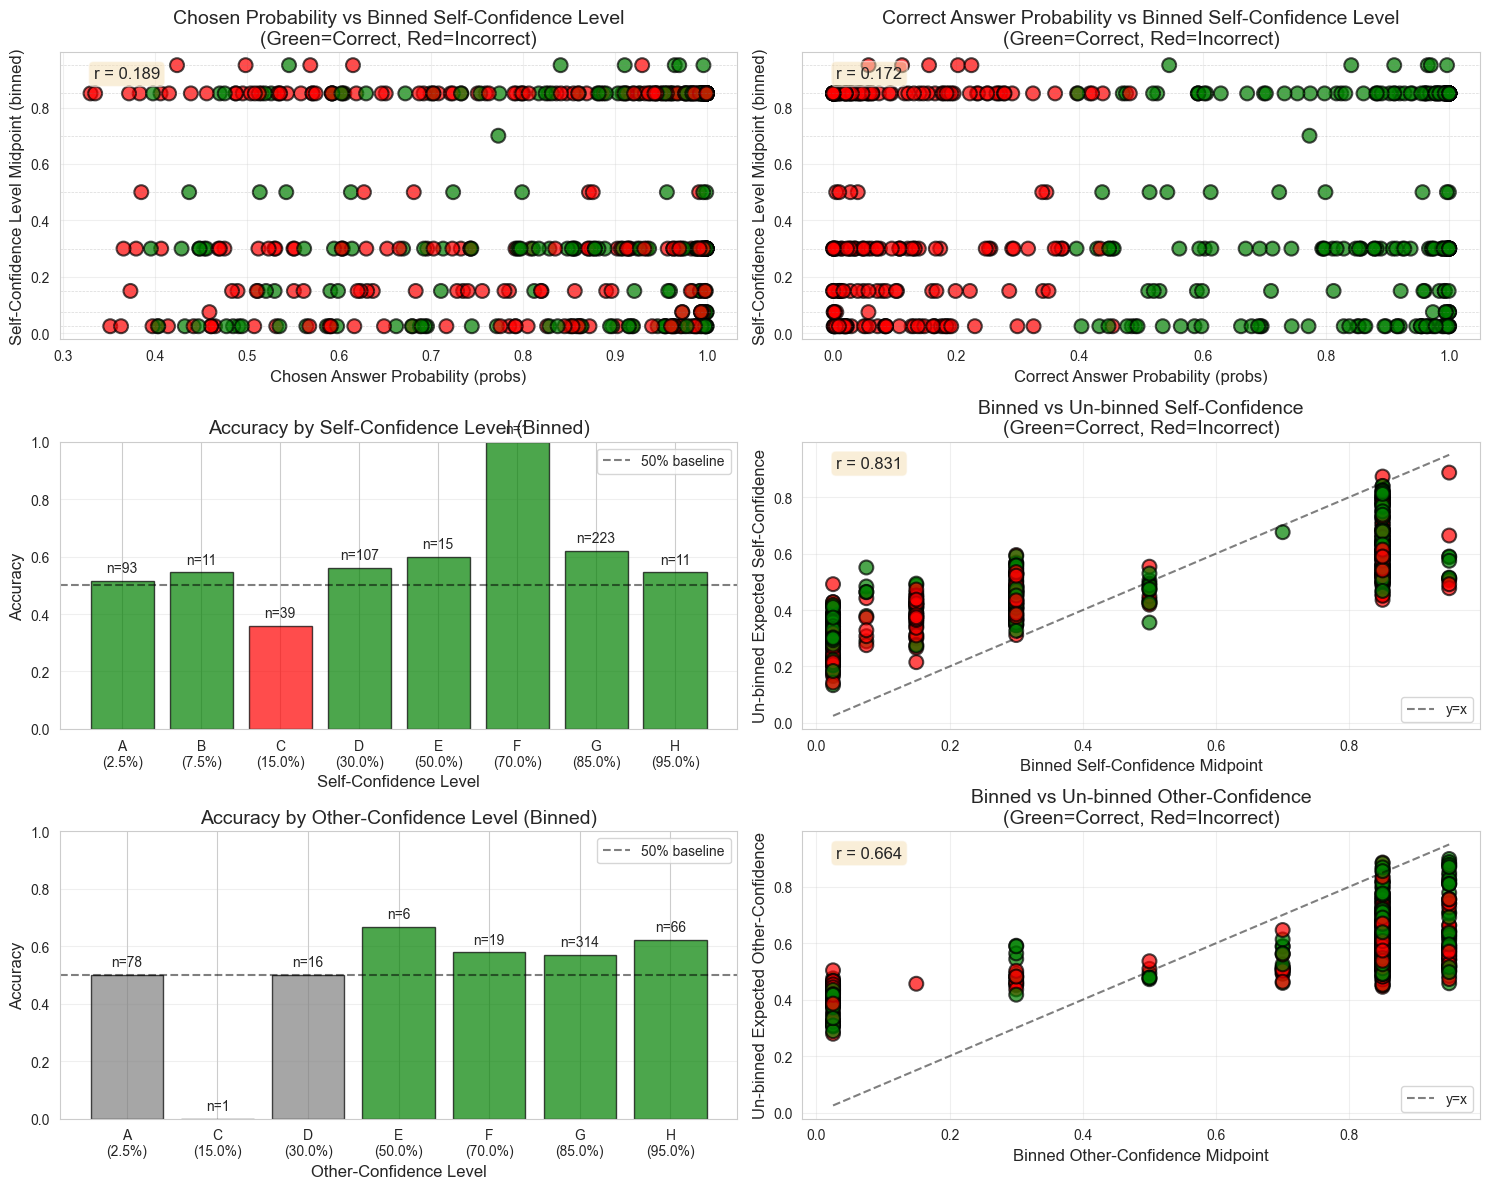

In [15]:
# Visualization: Binned confidence analysis
has_other = df['expected_other_confidence'].notna().any()
n_rows = 3 if has_other else 2
fig, axes = plt.subplots(n_rows, 2, figsize=(15, 12 if has_other else 12))

# 1. Chosen probability vs Self-confidence midpoint (binned)
ax = axes[0, 0]
scatter = ax.scatter(df['chosen_prob'], df['self_confidence_midpoint'], 
                     c=df['is_correct'].map({True: 'green', False: 'red'}),
                     s=100, alpha=0.7, edgecolors='black', linewidth=1.5)
ax.set_xlabel('Chosen Answer Probability (probs)', fontsize=12)
ax.set_ylabel('Self-Confidence Level Midpoint (binned)', fontsize=12)
ax.set_title('Chosen Probability vs Binned Self-Confidence Level\n(Green=Correct, Red=Incorrect)', fontsize=14)
ax.grid(True, alpha=0.3)
corr_binned = df['chosen_prob'].corr(df['self_confidence_midpoint'])
ax.text(0.05, 0.95, f'r = {corr_binned:.3f}', transform=ax.transAxes, 
        fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
# Add horizontal lines for confidence level boundaries
for level, midpoint in sorted(confidence_midpoints.items(), key=lambda x: x[1]):
    ax.axhline(midpoint, color='gray', linestyle='--', alpha=0.3, linewidth=0.5)

# 2. Correct probability vs Self-confidence midpoint (binned)
ax = axes[0, 1]
scatter = ax.scatter(df['correct_prob'], df['self_confidence_midpoint'], 
                     c=df['is_correct'].map({True: 'green', False: 'red'}),
                     s=100, alpha=0.7, edgecolors='black', linewidth=1.5)
ax.set_xlabel('Correct Answer Probability (probs)', fontsize=12)
ax.set_ylabel('Self-Confidence Level Midpoint (binned)', fontsize=12)
ax.set_title('Correct Answer Probability vs Binned Self-Confidence Level\n(Green=Correct, Red=Incorrect)', fontsize=14)
ax.grid(True, alpha=0.3)
corr_correct_binned = df['correct_prob'].corr(df['self_confidence_midpoint'])
ax.text(0.05, 0.95, f'r = {corr_correct_binned:.3f}', transform=ax.transAxes, 
        fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
for level, midpoint in sorted(confidence_midpoints.items(), key=lambda x: x[1]):
    ax.axhline(midpoint, color='gray', linestyle='--', alpha=0.3, linewidth=0.5)

# 3. Accuracy by self-confidence level (bar plot)
ax = axes[1, 0]
conf_levels = sorted(df['self_confidence_answer'].unique(), 
                     key=lambda x: confidence_midpoints[x])
conf_labels = [f"{level}\n({confidence_midpoints[level]:.1%})" for level in conf_levels]
accuracies = [df[df['self_confidence_answer'] == level]['is_correct'].mean() 
              for level in conf_levels]
counts = [df[df['self_confidence_answer'] == level].shape[0] 
          for level in conf_levels]
colors = ['green' if acc > 0.5 else 'red' if acc < 0.5 else 'gray' for acc in accuracies]
bars = ax.bar(conf_labels, accuracies, color=colors, alpha=0.7, edgecolor='black')
ax.set_xlabel('Self-Confidence Level', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Accuracy by Self-Confidence Level (Binned)', fontsize=14)
ax.set_ylim([0, 1])
ax.axhline(0.5, color='black', linestyle='--', alpha=0.5, label='50% baseline')
ax.grid(True, alpha=0.3, axis='y')
# Add count labels on bars
for i, (bar, count) in enumerate(zip(bars, counts)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'n={count}', ha='center', va='bottom', fontsize=10)
ax.legend()

# 4. Comparison: Binned vs Un-binned self-confidence
ax = axes[1, 1]
ax.scatter(df['self_confidence_midpoint'], df['expected_self_confidence'], 
           c=df['is_correct'].map({True: 'green', False: 'red'}),
           s=100, alpha=0.7, edgecolors='black', linewidth=1.5)
# Add diagonal line
min_val = min(df['self_confidence_midpoint'].min(), df['expected_self_confidence'].min())
max_val = max(df['self_confidence_midpoint'].max(), df['expected_self_confidence'].max())
ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='y=x')
ax.set_xlabel('Binned Self-Confidence Midpoint', fontsize=12)
ax.set_ylabel('Un-binned Expected Self-Confidence', fontsize=12)
ax.set_title('Binned vs Un-binned Self-Confidence\n(Green=Correct, Red=Incorrect)', fontsize=14)
ax.grid(True, alpha=0.3)
corr_bin_unbin = df['self_confidence_midpoint'].corr(df['expected_self_confidence'])
ax.text(0.05, 0.95, f'r = {corr_bin_unbin:.3f}', transform=ax.transAxes, 
        fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax.legend()

# 5-6. Other-confidence visualizations (if available)
if has_other:
    df_other = df[df['expected_other_confidence'].notna()]
    
    # 5. Accuracy by other-confidence level (bar plot)
    ax = axes[2, 0]
    conf_levels_other = sorted(df_other['other_confidence_answer'].unique(), 
                         key=lambda x: confidence_midpoints[x])
    conf_labels_other = [f"{level}\n({confidence_midpoints[level]:.1%})" for level in conf_levels_other]
    accuracies_other = [df_other[df_other['other_confidence_answer'] == level]['is_correct'].mean() 
                  for level in conf_levels_other]
    counts_other = [df_other[df_other['other_confidence_answer'] == level].shape[0] 
              for level in conf_levels_other]
    colors_other = ['green' if acc > 0.5 else 'red' if acc < 0.5 else 'gray' for acc in accuracies_other]
    bars_other = ax.bar(conf_labels_other, accuracies_other, color=colors_other, alpha=0.7, edgecolor='black')
    ax.set_xlabel('Other-Confidence Level', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title('Accuracy by Other-Confidence Level (Binned)', fontsize=14)
    ax.set_ylim([0, 1])
    ax.axhline(0.5, color='black', linestyle='--', alpha=0.5, label='50% baseline')
    ax.grid(True, alpha=0.3, axis='y')
    # Add count labels on bars
    for i, (bar, count) in enumerate(zip(bars_other, counts_other)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'n={count}', ha='center', va='bottom', fontsize=10)
    ax.legend()
    
    # 6. Comparison: Binned vs Un-binned other-confidence
    ax = axes[2, 1]
    ax.scatter(df_other['other_confidence_midpoint'], df_other['expected_other_confidence'], 
               c=df_other['is_correct'].map({True: 'green', False: 'red'}),
               s=100, alpha=0.7, edgecolors='black', linewidth=1.5)
    # Add diagonal line
    min_val_other = min(df_other['other_confidence_midpoint'].min(), df_other['expected_other_confidence'].min())
    max_val_other = max(df_other['other_confidence_midpoint'].max(), df_other['expected_other_confidence'].max())
    ax.plot([min_val_other, max_val_other], [min_val_other, max_val_other], 'k--', alpha=0.5, label='y=x')
    ax.set_xlabel('Binned Other-Confidence Midpoint', fontsize=12)
    ax.set_ylabel('Un-binned Expected Other-Confidence', fontsize=12)
    ax.set_title('Binned vs Un-binned Other-Confidence\n(Green=Correct, Red=Incorrect)', fontsize=14)
    ax.grid(True, alpha=0.3)
    corr_bin_unbin_other = df_other['other_confidence_midpoint'].corr(df_other['expected_other_confidence'])
    ax.text(0.05, 0.95, f'r = {corr_bin_unbin_other:.3f}', transform=ax.transAxes, 
            fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax.legend()

plt.tight_layout()
plt.show()
